# Code to simulate LMG Model
We have the following Hamiltonian
\begin{align}
H&=-\frac{J}{N}\sum_{i<j}\gamma_z \sigma_{i}^{z}\sigma_{j}^{z}+\gamma_y \sigma_{i}^{y}\sigma_{j}^{y}-\Gamma\sum_{i}\sigma_{i}^{x}
\end{align}
This reduces to (See ~/Dropbox/Research_Projects_Current/LMG_quench/LMG_quench.lyx),
\begin{equation}
\frac{J}{2}\left(\gamma_{z}-\frac{\gamma_{y}N}{2}\right)-\frac{J\left(2\gamma_{z}-\gamma_{y}\right)}{N}S_{z}^{2}+\frac{J\gamma_{y}}{2N}\left(S_{+}^{2}+S_{-}^{2}\right)-\Gamma\left(S_{+}+S_{-}\right)
\end{equation}
with the matrix elements,
\begin{align}
\left\langle S=\frac{N}{2},M\right|H\left|S=\frac{N}{2},M^{\prime}\right\rangle 	=&\delta_{MM^{\prime}}\left[\frac{J}{2}\left(\gamma_{z}+\gamma_{y}\left(1-\frac{2S\left(S+1\right)}{N}\right)\right)-\frac{J\left(2\gamma_{z}-\gamma_{y}\right)}{N}M^{2}\right]+ \nonumber \\
	&\ \ \ \delta_{MM^{\prime}-2}\left[\frac{J\gamma_{y}}{2N}\sqrt{\left(S\left(S+1\right)-\left(M+2\right)\left(M+1\right)\right)\left(S\left(S+1\right)-M\left(M+1\right)\right)}\right]+\nonumber \\
	&\ \ \ \delta_{MM^{\prime}+2}\left[\frac{J\gamma_{y}}{2N}\sqrt{\left(S\left(S+1\right)-\left(M-2\right)\left(M-1\right)\right)\left(S\left(S+1\right)-M\left(M-1\right)\right)}\right]+\nonumber \\
	&\ \ \ \delta_{MM^{\prime}-1}\left[-\Gamma\sqrt{\left(S\left(S+1\right)-M\left(M+1\right)\right)}\right]+\nonumber \\
	&\ \ \ \delta_{MM^{\prime}+1}\left[-\Gamma\sqrt{\left(S\left(S+1\right)-M\left(M-1\right)\right)}\right]
\end{align}

In [2]:
import numpy as np
from scipy import linalg as LA
import scipy.sparse.linalg as spla
from scipy import optimize as OPT
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm 
from latex_envs.latex_envs import figcaption
from scipy.special import binom as bm
from sympy.physics.quantum.cg import CG
import numpy.matlib
#import chardet
import os
import mod_LMG_v1 as LMG
import h5py
from mpl_toolkits.mplot3d import Axes3D
#for Latex font on figures
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Roman']})
rc('text', usetex=True)

# Ground state properties
We look at the ground state phase diagram of the postquench Hamiltonian

## Magnetization as a function of $\Gamma$ and system size dependence
We plot the magnetization as a function of the magnetice field, and also obtain the system size dependence. The ground state is expected to show,
\begin{equation}
\langle m^2\rangle=L^{-2/3}
\end{equation}


In [569]:
#calculate magnetization as a function of magnetic field
#tests magnetizationz2
Γarr=np.linspace(0.,2,40)
Larr=np.arange(100,1000,100)#np.concatenate([np.arange(100,1000,100),np.arange(1000,2000,1000)])#choose even
magϕsqlist=np.ones([np.size(Γarr),1])
magzsqlist=np.ones([np.size(Γarr),1])
magysqlist=np.ones([np.size(Γarr),1])
criticalmagϕsqlist=np.ones([np.size(Larr),1])
criticalmagzsqlist=np.ones([np.size(Larr),1])
criticalmagysqlist=np.ones([np.size(Larr),1])
for p in range(np.size(Γarr)):
    L=100
    print(p, end='\r', flush=True)
    paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γz=1.,γy=0,Γ=Γarr[p]) 
    Ham=LMG.LMG_generateHam(paramvals)
    GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
    GState=vec[:,0]
    magzsqlist[p]=LMG.magnetizationϕ2(GState,paramvals,1,0)
    magysqlist[p]=LMG.magnetizationϕ2(GState,paramvals,0,1)
    magϕsqlist[p]=magzsqlist[p]+magysqlist[p]
for q in range(np.size(Larr)):
    L=Larr[q]
    print(q, end='\r', flush=True)
    paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γz=1.,γy=0.,Γ=1) 
    Ham=LMG.LMG_generateHam(paramvals)
    GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
    GState=vec[:,0]
    criticalmagzsqlist[q]=LMG.magnetizationϕ2(GState,paramvals,1,0)
    criticalmagysqlist[q]=LMG.magnetizationϕ2(GState,paramvals,0,1)
    criticalmagϕsqlist[q]=criticalmagzsqlist[q]+criticalmagysqlist[q]
criticalΓ=paramvals.J*max(paramvals.γz,paramvals.γy)

In [570]:
#fitting to system size dependence
#linear fit to data
logSϕ=np.log10(criticalmagϕsqlist)
logSz=np.log10(criticalmagzsqlist)
logSy=np.log10(criticalmagysqlist)
logx=np.log10(Larr)
mϕ,bϕ = np.polyfit(logx,logSϕ, 1)
mz,bz = np.polyfit(logx,logSz, 1)
my,by = np.polyfit(logx,logSy, 1)

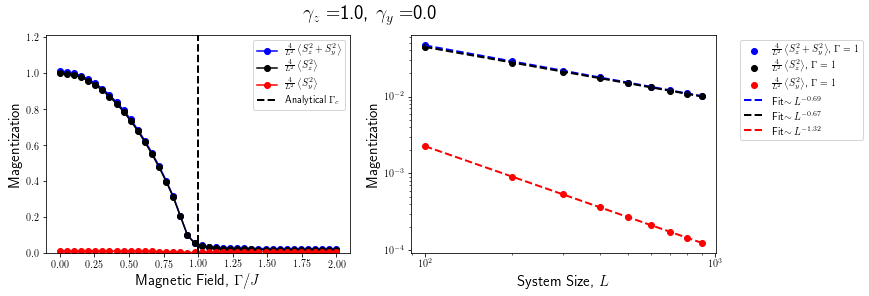

In [571]:
#plotting
plt.figure(figsize=(12,4))
plt.suptitle("$\\gamma_z=$"+str(paramvals.γz)+", $\\gamma_y=$"+str(paramvals.γy),fontsize=20)
plt.subplot(1,2,1)
plt.plot(Γarr, magϕsqlist,'-o',color='blue',label='$\\frac{4}{L^2}\\left\\langle S_z^2+S_y^2\\right\\rangle$')
plt.plot(Γarr, magzsqlist,'-o',color='black',label='$\\frac{4}{L^2}\\left\\langle S_z^2\\right\\rangle$')
plt.plot(Γarr, magysqlist,'-o',color='red',label='$\\frac{4}{L^2}\\left\\langle S_y^2\\right\\rangle$')
plt.axvline(criticalΓ,linestyle='dashed',color= 'black',label='Analytical $\\Gamma_c$',linewidth=2)
plt.ylim([0,np.max(magϕsqlist)+0.2])
plt.xlabel("Magnetic Field, $\\Gamma/J$",fontsize=15)
plt.ylabel("Magentization",fontsize=15)
plt.legend()
plt.subplot(1,2,2)
plt.loglog(Larr,criticalmagϕsqlist,'o',color='blue',label='$\\frac{4}{L^2}\\left\\langle S_z^2+S_y^2\\right\\rangle$, $\Gamma=1$')
plt.loglog(Larr,criticalmagzsqlist,'ko',color='black',label='$\\frac{4}{L^2}\\left\\langle S_z^2\\right\\rangle$, $\Gamma=1$')
plt.loglog(Larr,criticalmagysqlist,'ro',color='red',label='$\\frac{4}{L^2}\\left\\langle S_y^2\\right\\rangle$, $\Gamma=1$')
plt.loglog(Larr,(10**bϕ)*(Larr)**mϕ,'--',linewidth=2,color='blue',label='Fit$\\sim L^{%0.2f}$' % mϕ)
plt.loglog(Larr,(10**bz)*(Larr)**mz,'--',linewidth=2,color='black',label='Fit$\\sim L^{%0.2f}$' % mz)
plt.loglog(Larr,(10**by)*(Larr)**my,'--',linewidth=2,color='red',label='Fit$\\sim L^{%0.2f}$' % my)
plt.xlabel("System Size, $L$",fontsize=15)
plt.ylabel("Magentization",fontsize=15)
plt.legend(bbox_to_anchor=(1.5,1))
figcaption("(a)Magnetization as a function of magnetic field with dashed line showing analytical expectation (b) $L$ dependence of magnetization at the critical point. Seems like it agrees with $M^2\sim N^{-2/3}$")

# Magnetization as a function if $\gamma_x$ and $\gamma_y$ for a fixed $\Gamma$
In this we plot a 2-d color plot of magnetization as a function of $\gamma_x$ and $\gamma_y$.
We consider the slices :
\begin{itemize}
\item $\Gamma=1$
\item $\Gamma=4$
\end{itemize}

In [185]:
#calculate magnetization as a function of magnetic field
#tests magnetizationz2
Γ=4
γzarr=np.linspace(0.,2*Γ,40)
γyarr=np.linspace(0.,2*Γ,40)
L=100#choose even
magsqlist=np.ones([np.size(γzarr),np.size(γyarr)])
criticalmagsqlist=np.ones([np.size(Larr),1])
for p in range(np.size(γzarr)):
    for q in range(np.size(γyarr)):
        print([p,q], end='\r', flush=True)
        paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γz=γzarr[p],γy=γyarr[q],Γ=Γ) 
        Ham=LMG.LMG_generateHam(paramvals)
        GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
        GState=vec[:,0]
        magsqlist[p,q]=LMG.magnetizationϕ2(GState,paramvals,1,0)+LMG.magnetizationϕ2(GState,paramvals,0,1)

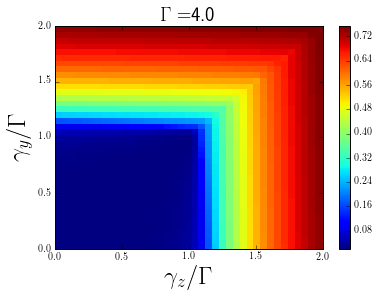

In [190]:
plt.figure(figsize=(6,4))
plt.title("$\\Gamma=$"+str(paramvals.Γ),fontsize=20)
X,Y = np.meshgrid(γzarr,γyarr)

plt.pcolormesh(X/Γ,Y/Γ,magsqlist)
plt.xlabel("$\gamma _z/\Gamma$",fontsize=25)
plt.ylabel("$\gamma_y/\Gamma$",fontsize=25)
#plt.xticks(max(γzarr))
#plt.yticks(range(len(γyarr)), γyarr)
plt.colorbar()

## Phase diagram as a function of the anisotropy.
We would like to recover the phase diagram as a function of the anisotropy parameter $\gamma$. The attempt is to reproduce the Fig.1 in PHYSICAL REVIEW E 78, 021106 (2008). There are four phases depending on the density of states. We would like to obtain for following parameters. In the paper, the Hamiltonian is defined as,
\begin{equation}
H=-\frac{1}{N}(\gamma_x S_x^2+\gamma_yS_y^2)-hS_z
\end{equation}
The different phases parameterized by ($\gamma_x,\gamma_y,h$) are identified as
$I\rightarrow(1/2,1/3,1)
II\rightarrow (2,1/2,1)
III\rightarrow (5,-3,1)
IV \rightarrow(5,3,1)$.

Translating to my notation, $\gamma_x\rightarrow 2J$, $\gamma_y\rightarrow 2J\gamma$, $h\rightarrow 2\Gamma$. And the energies are ofset by a constant $E_{PhysRevE}=E-\frac{J}{2}(1+\gamma)$. So we have the following phases,
\begin{enumerate}
\item $I\rightarrow (J=1/4,\gamma=2/3,\Gamma=1/2)$
\item $II\rightarrow (J=1,\gamma=1/4,\Gamma=1/2)$
\item $III\rightarrow (J=5/2,\gamma=-3/5,\Gamma=1/2)$
\item $IV\rightarrow (J=5/2,\gamma=3/5,\Gamma=1/2)$
\end{enumerate}

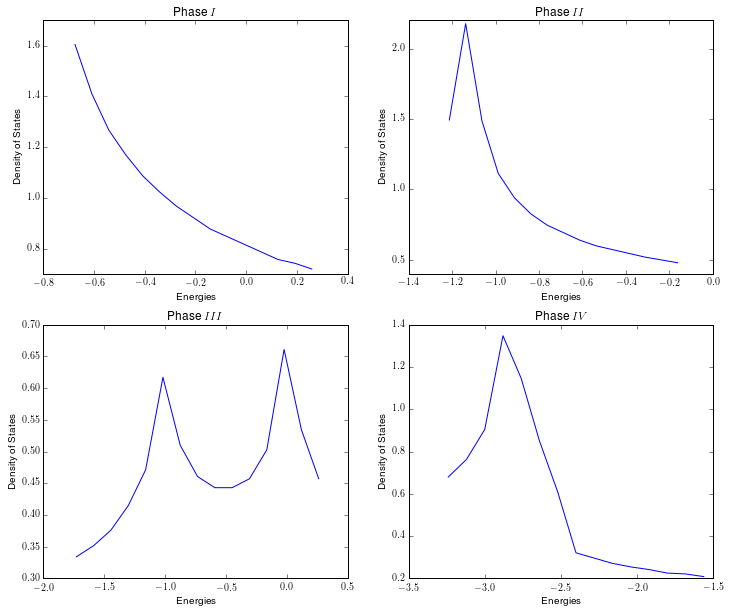

In [17]:
L=2000
plt.figure(figsize=[12,10])
#####Phase I
plt.subplot(2,2,1)
paramvals=LMG.Ham_params(N=L,S=L/2,J=1/4,γ=2/3,Γ=1/2)
Ham=LMG.LMG_generateHam(paramvals)
(Ham.transpose() == Ham).all() #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
counts,bin_edges = np.histogram(np.real(Energies), bins=15)
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
energypersite=bincenters/L-1/8*(1+2/3)
plt.plot(energypersite,counts/(np.sum(counts)*np.abs(energypersite[1]-energypersite[2])),'-')
plt.title('Phase $I$')
plt.xlabel('Energies')
plt.ylabel('Density of States')
#####Phase II
plt.subplot(2,2,2)
paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γ=1/4,Γ=1/2)
Ham=LMG.LMG_generateHam(paramvals)
(Ham.transpose() == Ham).all() #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
counts,bin_edges = np.histogram(np.real(Energies), bins=15)
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
energypersite=bincenters/L-1/2*(1+1/4)
plt.plot(energypersite,counts/(np.sum(counts)*np.abs(energypersite[1]-energypersite[2])),'-')
plt.title('Phase $II$')
plt.xlabel('Energies')
plt.ylabel('Density of States')
#####Phase III
plt.subplot(2,2,3)
paramvals=LMG.Ham_params(N=L,S=L/2,J=5/2,γ=-3/5,Γ=1/2)
Ham=LMG.LMG_generateHam(paramvals)
(Ham.transpose() == Ham).all() #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
counts,bin_edges = np.histogram(np.real(Energies), bins=15)
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
energypersite=bincenters/L-5/4*(1-3/5)
plt.plot(energypersite,counts/(np.sum(counts)*np.abs(energypersite[1]-energypersite[2])),'-')
plt.title('Phase $III$')
plt.xlabel('Energies')
plt.ylabel('Density of States')
#####Phase IV
plt.subplot(2,2,4)
paramvals=LMG.Ham_params(N=L,S=L/2,J=5/2,γ=3/5,Γ=1/2)
Ham=LMG.LMG_generateHam(paramvals)
(Ham.transpose() == Ham).all() #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
counts,bin_edges = np.histogram(np.real(Energies), bins=15)
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
energypersite=bincenters/L-5/4*(1+3/5)
plt.plot(energypersite,counts/(np.sum(counts)*np.abs(energypersite[1]-energypersite[2])),'-')
plt.title('Phase $IV$')
plt.xlabel('Energies')
plt.ylabel('Density of States')

# Properties of Excited States
$L$ dependence of $\langle S_z^2+S_y^2\rangle $ for low lying excited states. THe excited state total spin (atleast the low energies) exhibit a perfect scaling with system size as $\sim L^{4/3}$. 

In [42]:
#calculate magnetization as a function of magnetic field
#tests magnetizationz2
directory1='data/Energies_Eigenvecs/'
Larr=np.arange(5000,10000,2000)#np.concatenate([np.arange(100,1000,100),np.arange(1000,2000,1000)])#choose even
n_energies=20#number of excited states
Sϕsqlist=np.ones([np.size(Larr),n_energies])
Szsqlist=np.ones([np.size(Larr),n_energies])
Sysqlist=np.ones([np.size(Larr),n_energies])
for q in range(np.size(Larr)):
    L=Larr[q]
    paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γz=1.,γy=0.5,Γ=1) 
    filename=directory1+'Energies_Eigenvecs_'+paramvals.paramstr()+'n_energies_'+str(int(n_energies))+'.hdf5'
    if not os.path.exists(filename):
        Ham=LMG.LMG_generateHam(paramvals)
        energies,eigenvecs=spla.eigs(Ham,k=n_energies,which="SR")
        LMG.save_data_Energies_Eigenvecs(paramvals,energies,eigenvecs,n_energies)
    else:
        print("Loading file:"+filename)
        with h5py.File(filename, "r") as f:
            energies= f["energies"][...]
            eigenvecs=f["eigenvecs"][...]        
    for p in range(n_energies):
        print([q,p], end='\r', flush=True)
        State=eigenvecs[:,p]
        Szsqlist[q,p]=LMG.Sϕ2(State,paramvals,1,0)
        Sysqlist[q,p]=LMG.Sϕ2(State,paramvals,0,1)
        Sϕsqlist[q,p]=Szsqlist[q,p]+Sysqlist[q,p]

Loading file:data/Energies_Eigenvecs/Energies_Eigenvecs_L_5000,S_2500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.5n_energies_20.hdf5
Loading file:data/Energies_Eigenvecs/Energies_Eigenvecs_L_7000,S_3500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.5n_energies_20.hdf5
Loading file:data/Energies_Eigenvecs/Energies_Eigenvecs_L_9000,S_4500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.5n_energies_20.hdf5


Text(0.5, 1.0, '\\{$\\gamma_z= 1.0 $, $\\gamma_{y}= 0.5 $, $\\Gamma=1.0$\\}')

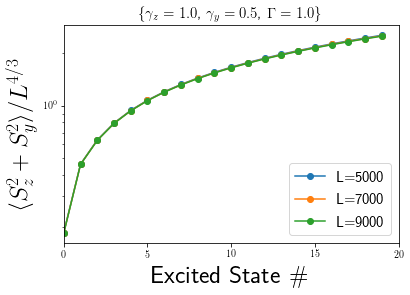

In [50]:
#plotting magsq for different system size as a function of energy level
for q in range(np.size(Larr)):
    L=Larr[q]
    plt.semilogy(range(n_energies),Sϕsqlist[q,:]/L**(4/3),'-o',label='L=%d'%Larr[q])
plt.xlabel("Excited State \\#",fontsize=25)
plt.ylabel("$\\langle S_z^2+S_y^2\\rangle/L^{4/3}$",fontsize=25)
plt.xlim(0,19)
#plt.ylim (1*10**4,5*10**5)
plt.xticks([0 ,5,10,15,20])
plt.legend(numpoints=1,loc=4,fontsize=15)
plt.title('\\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $, $\\Gamma=%.1f$\\}'%(paramvals.γz,paramvals.γy,paramvals.Γ),fontsize=15)
    

\subsection{Quench Protocol-I : Critical quench}
We start with an initial state and initial Hamiltonian,
\begin{align}
|\psi_{0}\rangle&=\text{Ground state of H_0} \\
\end{align}
In order to translate to notation in Mohammad's calculation and (Phys. Rev. B 74, 144423) we need to make a transformation that is done in LMG_quench.lyx.  

For the numerics we choose the parameters for the critical quench. We have the data for the following quenches
\begin{itemize}
\item $H_0$ is critical. $H_0\rightarrow \{ J_0=1$, $\gamma_{0z}=1$, $\gamma_{0y}=0$, $\Gamma=1\}$ to $H_f\rightarrow \{J=1$, $\gamma_z=0$, $\gamma_y=1$ $\Gamma=1\}$.
\item $H_0$ is critical. $H_0\rightarrow \{J_0=1$, $\gamma_{0z}=1$, $\gamma_{0y}=0$, $\Gamma=1\}$ to $H_f\rightarrow \{J=1$, $\gamma_z=1$, $\gamma_y=0.5$ $\Gamma=1\}$.
\item $H_0$ is deep in the paramagnetic phase. $H_0\rightarrow \{J_0=1$, $\gamma_{0z}=1$, $\gamma_{0y}=0$, $\Gamma=4\}$ to $H_f\rightarrow \{J=1$, $\gamma_z=0$, $\gamma_y=1$ $\Gamma=1\}$.
\end{itemize}


## A. Obtain time dependence of $\langle S_z^2+S_y^2\rangle $

In this section we focus on a particular system size, (say $L=100$) and plot the time dependence of the spin on th $y-z$ plane.



In [183]:
L=9000 #Set system size.
paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=0.,γy=1.,Γ=1.)
dt=0.2 #time step
Tf=20 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)

In [184]:
#run this or load file
directory1='data/Sϕ2t/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
directory5='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
#load Sz^2 data
filename1=directory5+'Sϕ2t_Az_1.0_Ay_0.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
#load Sy^2 data
filename2=directory5+'Sϕ2t_Az_0.0_Ay_1.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
    print("Data doesn't exist!")
else:
    print("Loading files:\n "+filename1+"\n"+filename2)
    with h5py.File(filename1, "r") as f:
        Sz2arr= f["Sϕ2arr"][...]
        InitState=f["InitState"][...]
    with h5py.File(filename2, "r") as f:
        Sy2arr= f["Sϕ2arr"][...]
        InitState=f["InitState"][...]

Loading files:
 /home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/Sϕ2t_Az_1.0_Ay_0.0_[0_0.2_20.0]_from_L_9000,S_4500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0_to_L_9000,S_4500.0,J_1.0,Γ_1.0,γz_0.0,γy_1.0.hdf5
/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/Sϕ2t_Az_0.0_Ay_1.0_[0_0.2_20.0]_from_L_9000,S_4500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0_to_L_9000,S_4500.0,J_1.0,Γ_1.0,γz_0.0,γy_1.0.hdf5


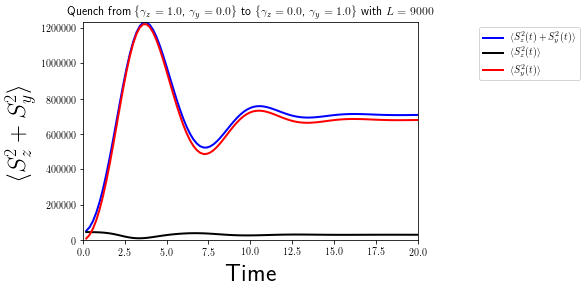

In [185]:
Syz2=Sz2arr+Sy2arr
#plotting
plt.plot(tarr,Syz2,'-',color='blue',linewidth=2,label='$\\langle S_z^2(t)+ S_y^2(t)\\rangle$')
plt.plot(tarr,Sz2arr,'-',color='black',linewidth=2,label='$\\langle S_z^2(t)\\rangle$')
plt.plot(tarr,Sy2arr,'-',color='red',linewidth=2,label='$\\langle S_y^2(t)\\rangle$')
#plt.plot(np.linspace(0,Tf,1000),Szt,color='blue',label='Holstein-Primakoff',linewidth=1.5)
#plt.axhline(Sz2inf,linestyle='dashed',color= 'black',label='$t=\\infty$ avg',linewidth=2)
plt.xlabel("Time",fontsize=25)
plt.ylabel("$\\langle S_z^2+S_y^2\\rangle$",fontsize=25)
plt.xlim(0,20)
plt.ylim(0,np.max(Syz2)+100)
plt.legend(numpoints=1,bbox_to_anchor=(1.5,1))
plt.title('Quench from \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} to \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} with $L=%d$'%(paramvals0.γz,paramvals0.γy, paramvalsf.γz,paramvalsf.γy,L))
figcaption("Time-dependence of the total spin for a system size $L=1000$ with the quench parameters shown in the figure. ")

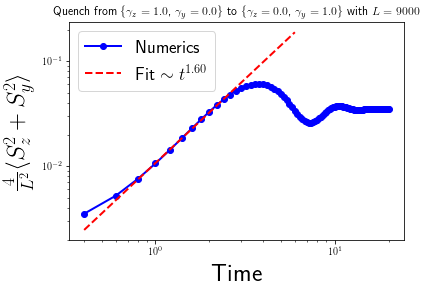

In [222]:
#plot in log scale
Syz2=Sz2arr+Sy2arr
#plotting
θ=1.6
plt.loglog(tarr[1:],Syz2[1:]*4/L**2,'-o',color='blue',linewidth=2,label='Numerics')
plt.loglog(tarr[1:30],(10**-1.97)*(tarr[1:30])**θ,'--',color='red',linewidth=2,label='Fit $\\sim t^{%.2f}$'%θ)
#plt.plot(np.linspace(0,Tf,1000),Szt,color='blue',label='Holstein-Primakoff',linewidth=1.5)
#plt.axhline(Sz2inf,linestyle='dashed',color= 'black',label='$t=\\infty$ avg',linewidth=2)
plt.xlabel("Time",fontsize=25)
plt.ylabel("$\\frac{4}{L^2}\\langle S_z^2+S_y^2\\rangle$",fontsize=25)
plt.legend(numpoints=1,loc=2,fontsize=18)
plt.title('Quench from \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} to \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} with $L=%d$'%(paramvals0.γz,paramvals0.γy, paramvalsf.γz,paramvalsf.γy,L))
figname='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/plots/Aging_loglog_St_[0_'+str(dt)+'_'+str(Tf)+']_from_'+paramvals0.paramstr()+'to'+paramvalsf.paramstr()+'.pdf'

#plt.savefig(figname,bbox_inches="tight")

# B. $L$ dependence of the time-averaged-$\langle S_z^2+S_y^2\rangle$
Here we discuss the dependence on system size of the time-averaged correlator. Recall that we are quenching from one critical point to another. In this case, according to Mohammad's calculation using the Holstein Primakoff, it is expected that, for large $N$
\begin{align}
\overline{\langle(S_{{\rm tot}}^{z}(t))^{2}\rangle}\sim L^{4/3}
\end{align}

## Figure-1: Quench to the critical point. $H_0\equiv \{J_0=1$, $\gamma_{0z}=1$,$\gamma_{0y}=0$, $\Gamma_0=1\}$ to $H_f\equiv \{J_f=1$,  $\gamma_{fz}=0$,$\gamma_{fy}=1$, $\Gamma_f=1\}$

In [312]:
Larr=np.concatenate([np.arange(100,1000,100),np.arange(1000,10000,1000)]) #Set system size.
dt=0.2 #time step
Tf=20.#20 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)

In [314]:
directory1='data/Sϕ2t/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
directory5='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
Sϕ2vals=np.zeros((Nsteps,np.size(Larr)))
Sy2vals=np.zeros((Nsteps,np.size(Larr)))
Sz2vals=np.zeros((Nsteps,np.size(Larr)))
deletelist=np.array([],dtype=int)
for L,p in zip(Larr,range(np.size(Larr))):
    print('L='+str(L), end='\r', flush=True)
    paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
    paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=0.,γy=1.,Γ=1.)
    #load Sz^2 data
    filename1=directory5+'Sϕ2t_Az_1.0_Ay_0.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    #load Sy^2 data
    filename2=directory5+'Sϕ2t_Az_0.0_Ay_1.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
        print("L="+str(L)+" data doesn't exist!")
        deletelist=np.append(deletelist,int(p))
    else:
        #print("Loading files:\n "+filename1+"\n"+filename2)
        with h5py.File(filename1, "r") as f:
            Sz2arr= f["Sϕ2arr"][...]
            InitState=f["InitState"][...]
        with h5py.File(filename2, "r") as f:
            Sy2arr= f["Sϕ2arr"][...]
            InitState=f["InitState"][...]
        Sϕ2vals[:,p]=Sz2arr+Sy2arr
        Sz2vals[:,p]=Sz2arr
        Sy2vals[:,p]=Sy2arr
Sϕ2vals_nonzero=np.delete(Sϕ2vals,deletelist,axis=1)
Sy2vals_nonzero=np.delete(Sy2vals,deletelist,axis=1)
Sz2vals_nonzero=np.delete(Sz2vals,deletelist,axis=1)
Larr_nonzero=np.delete(Larr,deletelist,axis=0)

L=800 data doesn't exist!
L=2000 data doesn't exist!
L=6000 data doesn't exist!


In [48]:
##numerical formulae for time-averaged value
Sϕtavg=np.mean(Sϕ2vals_nonzero, axis=0)
Sytavg=np.mean(Sy2vals_nonzero, axis=0)
Sztavg=np.mean(Sz2vals_nonzero, axis=0)
#linear fit to data
logSϕ=np.log10(np.divide(Sϕtavg,Larr_nonzero**2))
logSy=np.log10(np.divide(Sytavg,Larr_nonzero**2))
logSz=np.log10(np.divide(Sztavg,Larr_nonzero**2))
logL=np.log10(Larr_nonzero)
mϕ,bϕ = np.polyfit(logL,logSϕ, 1)
my,by = np.polyfit(logL,logSy, 1)
mz,bz = np.polyfit(logL,logSz, 1)
#plt.plot(logx,logy,'o')
#plt.plot(logx,m1*logx+b1,'--')

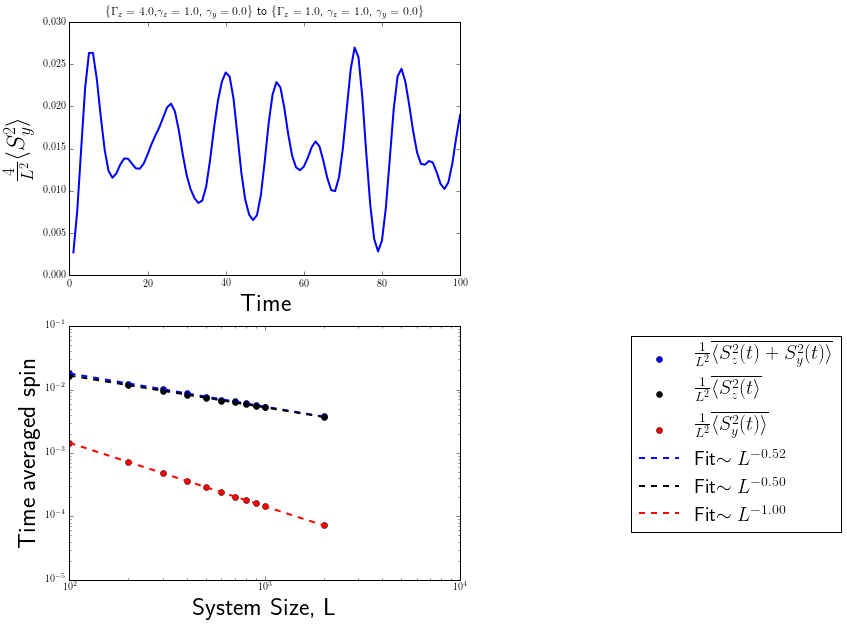

In [51]:
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)

#plot time dependence for largest system size
plt.plot(tarr,Sϕ2vals_nonzero[:,-1]*(4/Larr_nonzero[-1]**2),'-',color='blue',linewidth=2,label='$L=%d$'% L)
plt.xlabel("Time",fontsize=25)
plt.ylabel("$\\frac{4}{L^2}\\langle S_y^2\\rangle$",fontsize=25)#"+S_y^2\\rangle$",fontsize=25)
plt.xlim(0,tarr[-1])
#plt.ylim()
#plt.legend(numpoints=1,loc=1,fontsize=15)#bbox_to_anchor=(1.5,1))
plt.title(' \\{$\\Gamma_z= %.1f $,$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} to \\{$\\Gamma_z= %.1f $, $\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\}'%(paramvals0.Γ,paramvals0.γz,paramvals0.γy,paramvalsf.Γ, paramvalsf.γz,paramvalsf.γy))
figname='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/plots/For_Mohammad/Syt_[0_'+str(dt)+'_'+str(Tf)+']_from_'+paramvals0.paramstr()+'to'+paramvalsf.paramstr()+'.pdf'



#Plot average magnetization as a function of L
plt.subplot(2,1,2)
#plt.loglog(Larr,np.divide(np.abs(Sz2infarr-Sztavg),(Sz2infarr)),'o')
#plt.figure()
plt.loglog(Larr_nonzero,np.divide(Sϕtavg,Larr_nonzero**2),'bo',label='$\\frac{1}{L^2}\\overline{\\langle S_z^2(t)+ S_y^2(t)\\rangle}$')
plt.loglog(Larr_nonzero,np.divide(Sztavg,Larr_nonzero**2),'ko',label='$\\frac{1}{L^2}\\overline{\\langle S_z^2(t\\rangle}$')
plt.loglog(Larr_nonzero,np.divide(Sytavg,Larr_nonzero**2),'ro',label='$\\frac{1}{L^2}\\overline{\\langle S_y^2(t)\\rangle}$')
plt.loglog(Larr_nonzero,(10**bϕ)*(Larr_nonzero)**mϕ,'--',color='blue',linewidth=2,label='Fit$\\sim L^{%0.2f}$' % mϕ)
plt.loglog(Larr_nonzero,(10**bz)*(Larr_nonzero)**mz,'--',color='black',linewidth=2,label='Fit$\\sim L^{%0.2f}$' % mz)
plt.loglog(Larr_nonzero,(10**by)*(Larr_nonzero)**my,'--',color='red',linewidth=2,label='Fit$\\sim L^{%0.2f}$' % my)
plt.ylabel('Time averaged spin',fontsize=25)
plt.xlabel('System Size, L',fontsize=25)
#plt.title('Quench from  $\gamma_{z}=%0.1f$,$\gamma_{y}=%0.1f$ to  $\gamma_{z}=%0.1f$,$\gamma_{y}=%0.1f$'%{paramvals0.γz,paramvals0.γy.paramvalsf.γz,paramvalsf.γy},fontsize=25)
plt.legend(bbox_to_anchor=(2,1),numpoints=1,fontsize=20)
figcaption("Quench to the critical point. It is clear that the scaling with system size is $\sim N^{-1/3}$" )

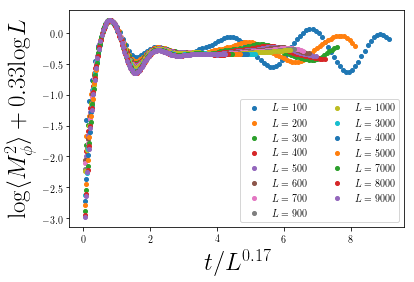

In [240]:
#Scaling Collapse over all times
#plt.plot(tarr,Mϕ2vals_nonzero,'-',linewidth=2,label='$\\langle S_z^2(t)+ S_y^2(t)\\rangle$')
mz=0.33#0.36
mt=0.17#0.18
for L,p in zip(Larr_nonzero,range(np.size(Larr_nonzero))):
    Mϕ2vals_nonzero=Sϕ2vals_nonzero*4/L**2
    plt.plot(tarr/L**mt,np.log(Mϕ2vals_nonzero[:,p])+mz*np.log(L),'.',markersize=8,linewidth=2,label='$L=%d$'% L)
plt.xlabel("$t/L^{ %0.2f } $"% mt,fontsize=25)
plt.ylabel("${\\rm log}\\langle M^2_\\phi \\rangle+ %0.2f {\\rm log}L$"% mz,fontsize=25)
plt.legend(loc=4,numpoints=1,ncol=2)
#plt.title(' \\{$\Gamma=%.1f, \\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} to \\{$\\Gamma=%.1f, \\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\}'%(paramvals0.Γ,paramvals0.γz,paramvals0.γy, paramvalsf.Γ,paramvalsf.γz,paramvalsf.γy))


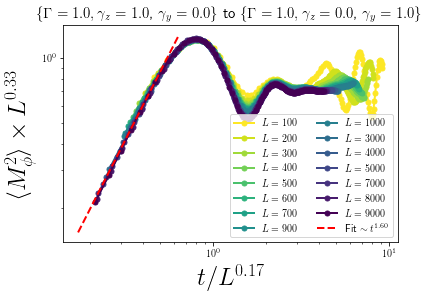

In [372]:
#Scaling collapse , loglog + short time 
#plt.plot(tarr,Mϕ2vals_nonzero,'-',linewidth=2,label='$\\langle S_z^2(t)+ S_y^2(t)\\rangle$')
mz=0.33#0.5#0.36
mt=0.17#0.25#0.18
θ=1.6#1.75
cmap=plt.cm.get_cmap('viridis_r')
stLind=0
colors = cmap(np.linspace(0,1,np.size(Larr_nonzero[stLind:])))
for L,p in zip(Larr_nonzero[stLind:],range(stLind,stLind+np.size(Larr_nonzero[stLind:]))):
    Mϕ2vals_nonzero=Sϕ2vals_nonzero*4/L**2
    plt.loglog((tarr[4:]/L**mt),((Mϕ2vals_nonzero[4:,p]))*(L**mz),'-o',color=colors[p-stLind],markersize=5,linewidth=2,label='$L=%d$'% L)
plt.loglog(tarr[3:15]/L**mt,(10**0.42)*(tarr[3:15]/L**mt)**θ,'--',color='red',linewidth=2,label='Fit $\\sim t^{%.2f}$'%θ)
#plt.xlim(0,1)
plt.xlabel("$t/L^{ %0.2f } $"% mt,fontsize=25)
plt.ylabel("$\\langle M^2_\\phi \\rangle \\times L^{%0.2f}$"% mz,fontsize=25)
plt.legend(loc=4,numpoints=1,ncol=2)
plt.title(' \\{$\Gamma=%.1f, \\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} to \\{$\\Gamma=%.1f, \\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\}'%(paramvals0.Γ,paramvals0.γz,paramvals0.γy, paramvalsf.Γ,paramvalsf.γz,paramvalsf.γy),fontsize=15)
figname='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/plots/Aging_loglog_excluded_All_L_St_[0_'+str(dt)+'_'+str(Tf)+']_from_'+paramvals0.paramstrwithoutLS()+'to'+paramvalsf.paramstrwithoutLS()+'.pdf'

plt.savefig(figname,bbox_inches="tight")

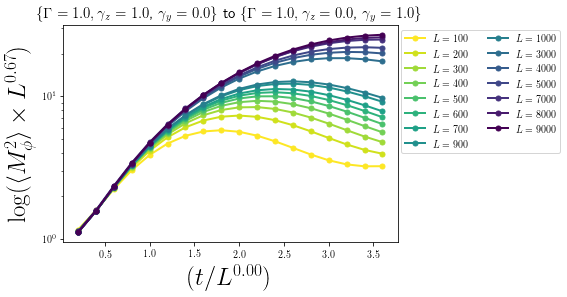

In [373]:
#Plot log-log scale and identify the N^# dependence of the time scale at short times
mz=0.67#0.5#0.36
mt=0.0#0.25#0.18
θ=1.75
tend=18
cmap=plt.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,np.size(Larr_nonzero)))
for L,p in zip(Larr_nonzero,range(np.size(Larr_nonzero))):
    Mϕ2vals_nonzero=(Sϕ2vals_nonzero*4/L**2)
    plt.semilogy((tarr[:tend]/L**mt),((Mϕ2vals_nonzero[:tend,p])*(L**mz)),'-o',color=colors[p],markersize=5,linewidth=2,label='$L=%d$'% L)
plt.xlabel("$(t/L^{ %0.2f }) $"% mt,fontsize=25)
plt.ylabel("$\\log(\\langle M^2_\\phi \\rangle \\times L^{%0.2f})$"% mz,fontsize=25)
plt.legend(bbox_to_anchor=(1.5,1),numpoints=1,ncol=2)


colors = cmap(np.linspace(0,1,tend))
#for t,p in zip(tarr[:tend],range(tend)):
#    plt.loglog(Larr_nonzero,Mϕ2vals_nonzero[p,:],'-o',color=colors[p],markersize=5,linewidth=2,label='$t=%.1f$'% t)
#plt.loglog(tarr[3:45]/L**mt,(10**0.42)*(tarr[3:45]/L**mt)**θ,'--',color='red',linewidth=2,label='Fit $\\sim t^{%.2f}$'%θ)
#plt.xlim(0,1)
#plt.xlabel("$L$",fontsize=25)
#plt.ylabel("$\\langle M^2_\\phi \\rangle \\times L^{%0.2f}$"% mz,fontsize=25)
plt.legend(bbox_to_anchor=(1.5,1),numpoints=1,ncol=2)
plt.title(' \\{$\Gamma=%.1f, \\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} to \\{$\\Gamma=%.1f, \\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\}'%(paramvals0.Γ,paramvals0.γz,paramvals0.γy, paramvalsf.Γ,paramvalsf.γz,paramvalsf.γy),fontsize=15)


#figname='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/plots/Aging_loglogII_All_L_St_[0_'+str(dt)+'_'+str(Tf)+']_from_'+paramvals0.paramstrwithoutLS()+'to'+paramvalsf.paramstrwithoutLS()+'.pdf'
#plt.savefig(figname,bbox_inches="tight")

figname='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/plots/Aging_semilogyII_All_L_St_[0_'+str(dt)+'_'+str(Tf)+']_from_'+paramvals0.paramstrwithoutLS()+'to'+paramvalsf.paramstrwithoutLS()+'.pdf'
plt.savefig(figname,bbox_inches="tight")

In [328]:
np.shape(Larr_nonzero)

(15,)

In [320]:
range(tend)

range(0, 5)

\subsection{Appendix: Quench Protocol: Sanity Checks}
We perform the following sanity check. We donot do a quench. Then there should be no time- depedence of $\langle S_z^2+S_y^2\rangle $ and the finite size depednece of long time magnetization should be identical to that of the ground state.

## Appendix Figure-2: No quench Time dependence of observables
$H_0\equiv \{J_0=1$, $\gamma_{0z}=1$,$\gamma_{0y}=0$, $\Gamma_0=1\}$ to $H_f\equiv \{J_f=1$,  $\gamma_{fz}=1$,$\gamma_{fy}=0$, $\Gamma_f=1\}$


In [139]:
L=1000 #Set system size.
paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
dt=0.2 #time step
Tf=20 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)

In [140]:
#run this or load file
directory1='data/Sϕ2t/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
#load Sz^2 data
filename1=directory2+'Sϕ2t_Az_1.0_Ay_0.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
#load Sy^2 data
filename2=directory2+'Sϕ2t_Az_0.0_Ay_1.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
    print("Data doesn't exist!")
else:
    print("Loading files:\n "+filename1+"\n"+filename2)
    with h5py.File(filename1, "r") as f:
        Sz2arr= f["Sϕ2arr"][...]
        InitState=f["InitState"][...]
    with h5py.File(filename2, "r") as f:
        Sy2arr= f["Sϕ2arr"][...]
        InitState=f["InitState"][...]

Loading files:
 /home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/Sϕ2t_Az_1.0_Ay_0.0_[0_0.2_20.0]_from_L_1000,S_500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0_to_L_1000,S_500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0.hdf5
/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/Sϕ2t_Az_0.0_Ay_1.0_[0_0.2_20.0]_from_L_1000,S_500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0_to_L_1000,S_500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0.hdf5


In [ ]:
#run this or load file
directory1='data/Sϕ2t/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
#load Sz^2 data
filename1=directory2+'Sϕ2t_Az_1.0_Ay_0.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
#load Sy^2 data
filename2=directory2+'Sϕ2t_Az_0.0_Ay_1.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
    print("Data doesn't exist!")
else:
    print("Loading files:\n "+filename1+"\n"+filename2)
    Syz2=Sz2arr+Sy2arrith h5py.File(filename1, "r") as f:
        Sz2arr= f["Sϕ2arr"][...]
        InitState=f["InitState"][...]
    with h5py.File(filename2, "r") as f:
        Sy2arr= f["Sϕ2arr"][...]
        InitState=f["InitState"][...]
Syz2=Sz2arr+Sy2arr

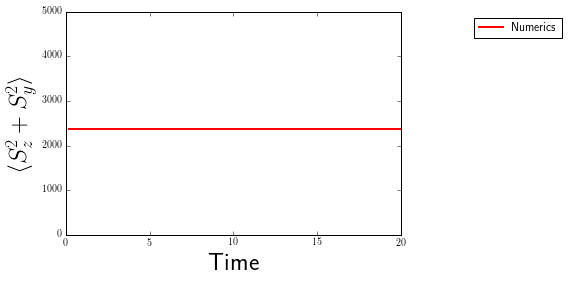

In [150]:
#plotting
plt.plot(tarr,Syz2,'-',color='red',linewidth=2,label='Numerics')
#plt.plot(np.linspace(0,Tf,1000),Szt,color='blue',label='Holstein-Primakoff',linewidth=1.5)
#plt.axhline(Sz2inf,linestyle='dashed',color= 'black',label='$t=\\infty$ avg',linewidth=2)
plt.xlabel("Time",fontsize=25)
plt.ylabel("$\\langle S_z^2+S_y^2\\rangle$",fontsize=25)
plt.xlim(0,20)
plt.ylim(0,5000)
plt.legend(numpoints=1,bbox_to_anchor=(1.5,1))
#plt.title('Quench from \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} to \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} with $L=%d$'%(paramvals0.γz,paramvals0.γy, paramvalsf.γz,paramvalsf.γy,L))

figcaption("Time-dependence of the total spin for a system size $L=1000$ when there is no quench. Note that if we zoom in , there is an oscillation with magnitude $\sim 0.03$ ")

## Appendix Figure-2: No quench, Size dependence
$H_0\equiv \{J_0=1$, $\gamma_{0z}=1$,$\gamma_{0y}=0$, $\Gamma_0=1\}$ to $H_f\equiv \{J_f=1$,  $\gamma_{fz}=1$,$\gamma_{fy}=0$, $\Gamma_f=1\}$


In [155]:
Larr=np.concatenate([np.arange(100,1000,100),np.arange(1000,10000,1000)]) #Set system size.
dt=0.2 #time step
Tf=20 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)

In [156]:
directory1='data/Sϕ2t/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
Sϕ2vals=np.zeros((Nsteps,np.size(Larr)))
deletelist=np.array([],dtype=int)
for L,p in zip(Larr,range(np.size(Larr))):
    print('L='+str(L), end='\r', flush=True)
    paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
    paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
    #load Sz^2 data
    filename1=directory2+'Sϕ2t_Az_1.0_Ay_0.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    #load Sy^2 data
    filename2=directory2+'Sϕ2t_Az_0.0_Ay_1.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
        print("L="+str(L)+" data doesn't exist!")
        deletelist=np.append(deletelist,int(p))
    else:
        #print("Loading files:\n "+filename1+"\n"+filename2)
        with h5py.File(filename1, "r") as f:
            Sz2arr= f["Sϕ2arr"][...]
            InitState=f["InitState"][...]
        with h5py.File(filename2, "r") as f:
            Sy2arr= f["Sϕ2arr"][...]
            InitState=f["InitState"][...]
        Sϕ2vals[:,p]=Sz2arr+Sy2arr
Sϕ2vals_nonzero=np.delete(Sϕ2vals,deletelist,axis=1)       
Larr_nonzero=np.delete(Larr,deletelist,axis=0)

L=800 data doesn't exist!
L=2000 data doesn't exist!
L=5000 data doesn't exist!
L=6000 data doesn't exist!
L=7000 data doesn't exist!
L=8000 data doesn't exist!
L=9000 data doesn't exist!


In [157]:
##numerical formulae for time-averaged value
Sϕtavg=np.mean(Sϕ2vals_nonzero, axis=0)
#linear fit to data
logy=np.log10(np.divide(Sϕtavg,Larr_nonzero**2))
logx=np.log10(Larr_nonzero)
m1,b1 = np.polyfit(logx,logy, 1)
#plt.plot(logx,logy,'o')
#plt.plot(logx,m1*logx+b1,'--')

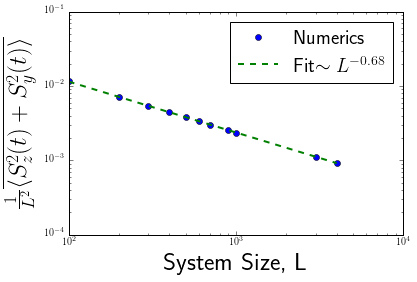

In [158]:
#Plot average magnetization as a function of L

#plt.loglog(Larr,np.divide(np.abs(Sz2infarr-Sztavg),(Sz2infarr)),'o')
plt.figure()
plt.loglog(Larr_nonzero,np.divide(Sϕtavg,Larr_nonzero**2),'o',label='Numerics')
plt.loglog(Larr_nonzero,(10**b1)*(Larr_nonzero)**m1,'--',linewidth=2,label='Fit$\\sim L^{%0.2f}$' % m1)
plt.ylabel('$\\frac{1}{L^2}\\overline{\\langle S_z^2(t)+ S_y^2(t)\\rangle}$',fontsize=25)
plt.xlabel('System Size, L',fontsize=25)
#plt.title('Quench from  $\gamma_{z}=%0.1f$,$\gamma_{y}=%0.1f$ to  $\gamma_{z}=%0.1f$,$\gamma_{y}=%0.1f$'%{paramvals0.γz,paramvals0.γy.paramvalsf.γz,paramvalsf.γy},fontsize=25)
plt.legend(loc=1,numpoints=1,fontsize=20)
figcaption("Quench to the same initial parameters $\{\gamma_{0z}=1,\gamma_{0y}=0\}=\{\gamma_{fz},\gamma_{fy}\}$. It is clear that the scaling with system size is $\sim N^{-2/3}$" )

# Aging
In this section we compare the prediction for aging. We start with small but finite magnetization $m^2$. We follow magnetization for the following quenches
\begin{itemize}
\item $H_0\rightarrow \{ J_0=1$, $\gamma_{0z}=1$, $\gamma_{0y}=0$, $\Gamma=0.8\}$ to $H_f\rightarrow \{J=1$, $\gamma_z=1$, $\gamma_y=0$ $\Gamma=1\}$
\end{itemize}

In [320]:
Larr=np.concatenate([np.arange(1000,4000,1000)]) #Set system size.
dt=0.2 #time step
Tf=100 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)

In [321]:
#run this or load file
directory1='data/Sϕ2t/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
deletelist=np.array([],dtype=int)
Sϕ2vals=np.zeros((Nsteps,np.size(Larr)))
Sy2vals=np.zeros((Nsteps,np.size(Larr)))
Sz2vals=np.zeros((Nsteps,np.size(Larr)))
for L,p in zip(Larr,range(np.size(Larr))):
    print('L='+str(L), end='\r', flush=True)
    paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=0.95)
    paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
    #load Sz^2 data
    filename1=directory2+'Sϕ2t_Az_1.0_Ay_0.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    #load Sy^2 data
    filename2=directory2+'Sϕ2t_Az_0.0_Ay_1.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
        print("Data doesn't exist!")
        deletelist=np.append(deletelist,int(p))
    else:
        print("Loading files:\n "+filename1+"\n"+filename2)
        with h5py.File(filename1, "r") as f:
            Sz2arr= f["Sϕ2arr"][...]
            InitState=f["InitState"][...]
        with h5py.File(filename2, "r") as f:
            Sy2arr= f["Sϕ2arr"][...]
            InitState=f["InitState"][...]
        Sϕ2vals[:,p]=Sz2arr+Sy2arr
        Sz2vals[:,p]=Sz2arr
        Sy2vals[:,p]=Sy2arr
Sϕ2vals_nonzero=np.delete(Sϕ2vals,deletelist,axis=1)
Sy2vals_nonzero=np.delete(Sy2vals,deletelist,axis=1)
Sz2vals_nonzero=np.delete(Sz2vals,deletelist,axis=1)
Larr_nonzero=np.delete(Larr,deletelist,axis=0)

Loading files:
 /home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/Sϕ2t_Az_1.0_Ay_0.0_[0_0.2_100.0]_from_L_1000,S_500.0,J_1.0,Γ_0.95,γz_1.0,γy_0.0_to_L_1000,S_500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0.hdf5
/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/Sϕ2t_Az_0.0_Ay_1.0_[0_0.2_100.0]_from_L_1000,S_500.0,J_1.0,Γ_0.95,γz_1.0,γy_0.0_to_L_1000,S_500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0.hdf5
Loading files:
 /home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/Sϕ2t_Az_1.0_Ay_0.0_[0_0.2_100.0]_from_L_2000,S_1000.0,J_1.0,Γ_0.95,γz_1.0,γy_0.0_to_L_2000,S_1000.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0.hdf5
/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/Sϕ2t_Az_0.0_Ay_1.0_[0_0.2_100.0]_from_L_2000,S_1000.0,J_1.0,Γ_0.95,γz_1.0,γy_0.0_to_L_2000,S_1000.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0.hdf5
Loading files:
 /home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/Sϕ2t_Az_1.0_Ay_0.0_[0_0.2_100.0]_from_L_3000,S_1500.0,J_1.0,Γ_0.95,γz_1.0,γy_0.0_to_L_3000,S_1500

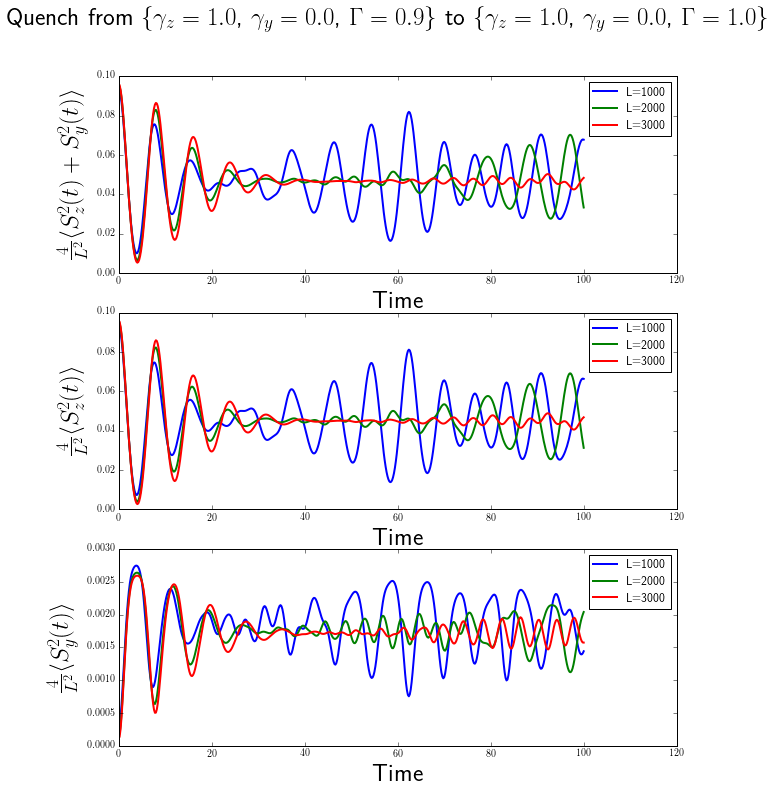

In [322]:
#plotting
plt.figure(figsize=[10,12])
for L,p in zip(Larr_nonzero,range(np.size(Larr_nonzero))):
    plt.subplot(3,1,1)
    plt.plot(tarr,np.divide(Sϕ2vals_nonzero[:,p],L**2/4),'-',linewidth=2,label='L=%d'%L)

    #plt.plot(np.linspace(0,Tf,1000),Szt,color='blue',label='Holstein-Primakoff',linewidth=1.5)
    #plt.axhline(Sz2inf,linestyle='dashed',color= 'black',label='$t=\\infty$ avg',linewidth=2)
    plt.xlabel("Time",fontsize=25)
    plt.ylabel("$\\frac{4}{L^2}\\langle S_z^2(t)+ S_y^2(t)\\rangle$",fontsize=25)
    #plt.xlim(0,20)
    #plt.ylim(0,np.max(Syz2)+100)
    plt.legend(numpoints=1)
    plt.subplot(3,1,2)
    plt.plot(tarr,np.divide(Sz2vals[:,p],L**2/4),'-',linewidth=2,label='L=%d'%L)
    plt.legend(numpoints=1)
    plt.xlabel("Time",fontsize=25)
    plt.ylabel("$\\frac{4}{L^2}\\langle S_z^2(t)\\rangle$",fontsize=25)
    plt.subplot(3,1,3)
    plt.plot(tarr,np.divide(Sy2vals[:,p],L**2/4),'-',linewidth=2,label='L=%d'%L)
    plt.legend(numpoints=1)
    plt.xlabel("Time",fontsize=25)
    plt.ylabel("$\\frac{4}{L^2}\\langle S_y^2(t)\\rangle$",fontsize=25)

plt.suptitle('Quench from \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $, $\Gamma=%.1f $\\} to \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $, $\Gamma=%.1f $\\}'%(paramvals0.γz,paramvals0.γy,paramvals0.Γ, paramvalsf.γz,paramvalsf.γy,paramvalsf.Γ),fontsize=25)
figcaption("Time-dependence of the spin for differnt system size $L=1000$ with the quench parameters shown in the figure. ")

figname='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/plots/Aging_St_[0_'+str(dt)+'_'+str(Tf)+']_from_'+paramvals0.paramstr()+'to'+paramvalsf.paramstr()+'.pdf'

plt.savefig(figname,bbox_inches="tight")

# Finite Temperature Physics: Phase diagram

In this section, we will try and obtain exponents at finite temperature for the critical points. 
First, let us start by checking the phase diagram.
We will consider the Hamiltonian with parameters $\gamma_z=1$, and $\gamma_y=1$
\begin{equation}
\beta=\frac{1}{2\Gamma}\log\left(\frac{J\gamma_{x,y}+\Gamma}{J\gamma_{x,y}-\Gamma}\right)
\end{equation}

In [191]:
#Finite temperature for very small temperature vs GState
L=50#Set system size.
β=1/0.7
Γarr=np.linspace(0.,2,40)
GSmagzsqlist=np.zeros([np.size(Γarr),1])
magsqβlist=np.zeros([np.size(Γarr),1])
for p in range(np.size(Γarr)):
    print(p, end='\r', flush=True)
    paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γz=1.,γy=0.,Γ=Γarr[p]) 
    magsqβlist[p]=Finitetempmagnetizationϕ2(paramvals,β,1.,0.)
    #print('mag='+str(magsqβlist[p]), end='\r', flush=True)
    #GS properties
    Ham=LMG.LMG_generateHam(paramvals)
    GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
    GState=vec[:,0]
    GSmagzsqlist[p]=LMG.magnetizationϕ2(GState,paramvals,1,0)

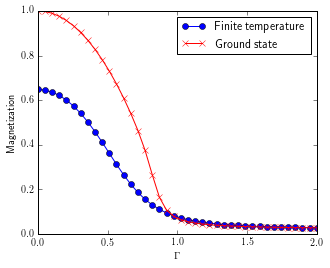

In [192]:
plt.figure(figsize=(5,4))
plt.plot(Γarr, magsqβlist,'-o',color='blue',label='Finite temperature')
plt.plot(Γarr, GSmagzsqlist,'-x',color='red',label='Ground state')
figcaption("Comparing the finite temperature prediction at really small temperature to ground state values")
plt.legend()
plt.xlabel("$\Gamma$")
plt.ylabel("Magnetization")

In [262]:
#Plot as a function of temperature for a fixed Γ
L=50#Set system size.
Γ=0.5
βarr=np.linspace(0.5,10,40)
GSmagzsqlist=np.zeros([np.size(βarr),1])
magsqβlist=np.zeros([np.size(βarr),1])
for p in range(np.size(βarr)):
    β=βarr[p]
    print([p,β], end='\r', flush=True)
    paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γz=1.,γy=0.,Γ=Γ) 
    magsqβlist[p]=Finitetempmagnetizationϕ2(paramvals,β,1.,0.)
    #print('mag='+str(magsqβlist[p]), end='\r', flush=True)
    #GS properties
    Ham=LMG.LMG_generateHam(paramvals)
    GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
    GState=vec[:,0]
    GSmagzsqlist[p]=LMG.magnetizationϕ2(GState,paramvals,1,0)

ZeroDivisionError: float division by zero

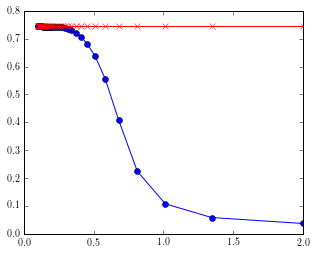

In [261]:
plt.figure(figsize=(5,4))
plt.plot(1/βarr, magsqβlist,'-o',color='blue',label='Finite temperature')
plt.plot(1/βarr, GSmagzsqlist,'-x',color='red',label='Ground state')
plt.axvline(2/(1/Γ*np.log((paramvals.J*paramvals.γz+paramvals.Γ)/(paramvals.J*paramvals.γz-paramvals.Γ))),linestyle='dashed')
figcaption("Comparing the finite temperature prediction at really small temperature to ground state values")
plt.legend(bbox_to_anchor=(1.6,0.5))
plt.xlabel("$1/\\beta$")
plt.ylabel("Magnetization")

In [163]:
L=50 #Set system size.
βarr=np.linspace(1.,10,22)
Γarr=np.linspace(0.,2,20)
magsqβlist=np.zeros([np.size(Γarr),np.size(βarr)])
for q in range(np.size(βarr)):
    β=βarr[q]
    for p in range(np.size(Γarr)):
        L=100
        print([q,p], end='\r', flush=True)
        paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γz=1.,γy=0.,Γ=Γarr[p]) 
        magsqβlist[p,q]=Finitetempmagnetizationϕ2(paramvals,β,1.,0.)
        


In [282]:
#analytical solution of the critical field
βarr=np.linspace(1.001,10,100)
def fun(Γ,*otherparams):
    β,γ,J=otherparams
    return np.log((J*γ+Γ)/(J*γ-Γ))-2*Γ*β
solarr=np.zeros(np.size(βarr))
for q in range(np.size(βarr)):
    β1=βarr[q] 
    if β1>1:
        otherparams=(β1,1.,1.) #(β,γ,J)
        solarr[q] =OPT.bisect(fun,0.01,0.999999999999,args=otherparams)

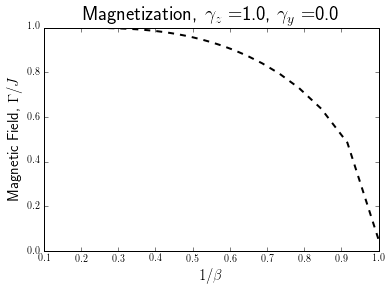

In [284]:
plt.figure(figsize=(6,4))
X,Y = np.meshgrid(1/βarr,Γarr)

#\plt.pcolormesh(X,Y,magsqβlist)
plt.plot(1/βarr,solarr,color="black",linestyle='dashed',linewidth=2)
plt.title("Magnetization, $\\gamma_z=$"+str(paramvals.γz)+", $\\gamma_y=$"+str(paramvals.γy),fontsize=20)
#
#plt.axvline(criticalΓ,linestyle='dashed',color= 'black',label='Analytical $\\Gamma_c$',linewidth=2)

plt.xlabel("$1/\\beta$",fontsize=15)
plt.ylabel("Magnetic Field, $\\Gamma/J$",fontsize=15)
#plt.colorbar()

In [4]:
#Function to calculate critical temperature at particular value of parameters for the Hamiltonian.
L=100
paramvals=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=0.8)
β=LMG.finitetemp_criticalβ(paramvals)
print(1/β)

0.728191381301


# Finite temperature exponents:
Here we obtain the finite size scaling exponents at the critical point. of $\langle S_\phi^\dagger S_\phi \rangle$


In [294]:
β=1/0.7
Larr=np.concatenate([np.arange(100,500,100)])#,np.arange(1000,2000,1000)])
L=100
paramvals=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1)

In [295]:
#obtain critical field
#analytical solution of the critical field
def fun(Γ,*otherparams):
    β1,γ1,J1=otherparams
    return np.log((J1*γ1+Γ)/(J1*γ1-Γ))-Γ*β1*2
if β>paramvals.J*np.max([paramvals.γy,paramvals.γz]):
    otherparams=(β,1.,1.) #(β,γ,J)
    Γsol =OPT.bisect(fun,0.01,0.9999999,args=otherparams)
else:
    print('No critical point')

0.8286347986394434

In [300]:
magsqβarr=np.zeros(np.size(Larr))
for p in range(np.size(Larr)):
    print(p, end='\r', flush=True)
    L=Larr[p]
    paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γz=1.,γy=0.,Γ=Γsol)
    magsqβarr[p]=Finitetempmagnetizationϕ2(paramvals,β,0.,1.)

In [301]:
#linear fit to data
logy=np.log10(magsqβarr)
logx=np.log10(Larr)
m1,b1 = np.polyfit(logx,logy, 1)

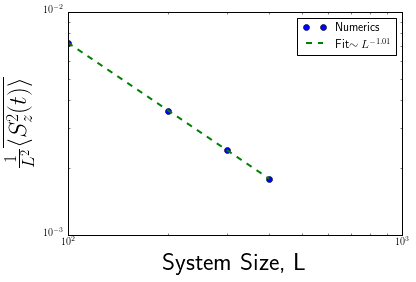

In [302]:
plt.figure()
plt.loglog(Larr,magsqβarr,'o',label='Numerics')
plt.loglog(Larr,(10**b1)*(Larr)**m1,'--',linewidth=2,label='Fit$\\sim L^{%0.2f}$' % m1)
plt.ylabel('$\\frac{1}{L^2}\\overline{\\langle S_z^2(t)\\rangle}$',fontsize=25)
plt.xlabel('System Size, L',fontsize=25)
plt.legend()

# Energy fluctuations in the quench
In this section, we compute the energy flucutatons. We calculate $\langle H_f^2\rangle_0$ and $\langle H_f \rangle_0$ and compute the following
\begin{eqnarray}
\Delta E=\left\langle H_f-H_0\right\rangle_0\\
(\Delta E)^2=\left\langle \left(H_f-H_0\right)^2\right\rangle_0\\
\sigma^2(E)=\left\langle H_f^2\right\rangle_0-\left\langle H_f\right\rangle_0^2
\end{eqnarray}

In [43]:
Larr=np.concatenate([np.arange(100,1000,100),np.arange(1000,4000,1000)]) #Set system size.
dt=0.2 #time step
Tf=20 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)
HfFESarr=np.zeros(np.size(Larr),dtype=complex)
HfGSarr=np.zeros(np.size(Larr),dtype=complex)
Hfarr=np.zeros(np.size(Larr),dtype=complex)
Hf2arr=np.zeros(np.size(Larr),dtype=complex)
H0arr=np.zeros(np.size(Larr),dtype=complex)
for L,p in zip(Larr,range(np.size(Larr))):
    print('L='+str(L), end='\r', flush=True)
    paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=4.)
    Ham=LMG.LMG_generateHam(paramvals0)
    GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
    GState=vec[:,0]
    paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
    Hamquench=LMG.LMG_generateHam(paramvalsf)
    energyf,vecf=spla.eigs(Hamquench,k=2,which="SR")
    GStatef=vecf[:,0]
    FEState=vecf[:,1]
    HfGSarr[p]=energyf[0]
    HfFESarr[p]=energyf[1]
    HamquenchonGState=np.matmul(Hamquench,GState)#H|ψ0>=|ψ1>   
    Hfarr[p]=np.matmul(np.transpose(np.conjugate(GState)),HamquenchonGState)#<ψ0|ψ1>=<H>_0
    Hf2arr[p]=np.matmul(np.transpose(np.conjugate(HamquenchonGState)),HamquenchonGState)#<ψ1|ψ1>=<H^2>
    H0arr[p]=GSenergy#<H_0>_0
print('Done',flush=True)
    

Done00


In [50]:
deletelist=np.where(np.logical_and(np.logical_and(Hfarr==0,Hf2arr==0),H0arr==0))[0]
ΔE=np.abs(Hfarr-H0arr)#energy into the quench
ΔEf=Hfarr-HfGSarr
ΔEfnorm=np.divide(Hfarr-HfGSarr,np.abs(HfGSarr-HfFESarr)) #energy density of the quench relative to GS of quench Hamiltonian
#ΔE2=Hf2arr+np.square(H0arr)-2*H0arr*Hfarr
varE=Hf2arr-np.square(Hfarr)
#print("Checking imaginary part of ΔE="+str(np.sum(np.imag(ΔE))))
#print("Checking imaginary part of ΔE2="+str(np.sum(np.imag(ΔE2))))
ΔE_nonzero=np.delete(np.real(ΔE),deletelist,axis=0)
#ΔE2_nonzero=np.delete(np.real(ΔE2),deletelist,axis=0)
Larr_nonzero=np.delete(Larr,deletelist,axis=0)
Hfarr_nonzero=np.delete(np.real(np.abs(Hfarr)),deletelist,axis=0)
varE_nonzero=np.delete(np.real(np.abs(varE)),deletelist,axis=0)
ΔEf_nonzero=np.delete(np.real(ΔEf),deletelist,axis=0)
ΔEfnorm_nonzero=np.delete(np.real(ΔEfnorm),deletelist,axis=0)

In [51]:
#linear fit to data
logy1=np.log10(ΔE_nonzero)
logx1=np.log10(Larr_nonzero)
m1,b1 = np.polyfit(logx1,logy1, 1)
#logy2=np.log10(ΔE2_nonzero)
#logx2=np.log10(Larr_nonzero)
#m2,b2 = np.polyfit(logx2,logy2, 1)
#logy3=np.log10(Hfarr_nonzero)
#logx3=np.log10(Larr_nonzero)
#m3,b3 = np.polyfit(logx3,logy3, 1)
logy4=np.log10(varE_nonzero)
logx4=np.log10(Larr_nonzero)
m4,b4 = np.polyfit(logx4,logy4, 1)
logy5=np.log10(ΔEf_nonzero)
logx5=np.log10(Larr_nonzero)
m5,b5 = np.polyfit(logx5,logy5, 1)
logy6=np.log10(ΔEfnorm_nonzero)
logx6=np.log10(Larr_nonzero)
m6,b6 = np.polyfit(logx6,logy6, 1)
#plt.plot(logx,logy,'o')
#plt.plot(logx,m1*logx+b1,'--')

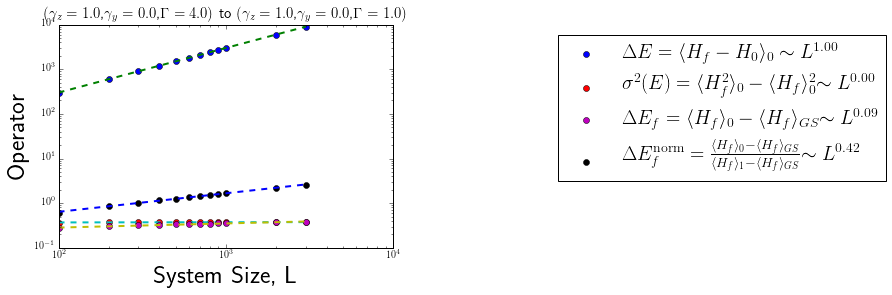

In [52]:
#Plot average magnetization as a function of L

#plt.loglog(Larr,np.divide(np.abs(Sz2infarr-Sztavg),(Sz2infarr)),'o')
plt.figure()
plt.loglog(Larr_nonzero,ΔE_nonzero,'o',label='$\Delta E=\langle H_f-H_0\\rangle_0\\sim L^{%0.2f}$' % m1)
plt.loglog(Larr_nonzero,(10**b1)*(Larr_nonzero)**m1,'--',linewidth=2)
#plt.loglog(Larr_nonzero,ΔE2_nonzero,'o',label='$(\Delta E)^2\\sim L^{%0.2f}$' % m2)
#plt.loglog(Larr_nonzero,(10**b2)*(Larr_nonzero)**m2,'--',linewidth=2)
#plt.loglog(Larr_nonzero,Hfarr_nonzero,'o',label='$\langle H_f\\rangle_0$\\sim L^{%0.2f}$' % m3)
#plt.loglog(Larr_nonzero,(10**b3)*(Larr_nonzero)**m3,'--',linewidth=2)
plt.loglog(Larr_nonzero,varE_nonzero,'o',label='$\sigma^2(E)=\langle H_f^2\\rangle_0-\langle H_f\\rangle_0^2$$\\sim L^{%0.2f}$' % m4)
plt.loglog(Larr_nonzero,(10**b4)*(Larr_nonzero)**m4,'--',linewidth=2)
#plt.loglog(Larr_nonzero,np.square(Hfarr),'-o',label='$\langle H_f\\rangle_0^2$' )
#plt.loglog(Larr_nonzero,Hf2arr,'-o',label='$\langle H_f^2\\rangle_0$' )
#
plt.loglog(Larr_nonzero,ΔEf_nonzero,'o',label='$\Delta E_f=\\langle H_f\\rangle_0-\langle H_f\\rangle_{GS}$$\\sim L^{%0.2f}$' % m5)
plt.loglog(Larr_nonzero,(10**b5)*(Larr_nonzero)**m5,'--',linewidth=2)
plt.loglog(Larr_nonzero,ΔEfnorm_nonzero,'o',label='$\Delta E^{\\rm norm}_f=\\frac{\langle H_f\\rangle_0-\langle H_f\\rangle_{GS}}{\langle H_f\\rangle_{1}-\langle H_f\\rangle_{GS}}$$\\sim L^{%0.2f}$' % m6)
plt.loglog(Larr_nonzero,(10**b6)*(Larr_nonzero)**m6,'--',linewidth=2)
plt.ylabel('Operator',fontsize=25)
plt.xlabel('System Size, L',fontsize=25)
plt.title('$(\gamma_{z}=%0.1f$,$\gamma_{y}=%0.1f$,$\Gamma=%0.1f)$ to  $(\gamma_{z}=%0.1f$,$\gamma_{y}=%0.1f$,$\Gamma=%0.1f)$'%(paramvals0.γz,paramvals0.γy,paramvals0.Γ,paramvalsf.γz,paramvalsf.γy,paramvalsf.Γ),fontsize=15)
#plt.title('Quench from  $(\gamma_{z}=%0.1f$) '% paramvals0.γz ,fontsize=25)

plt.legend(bbox_to_anchor=(2.5,1),numpoints=1,fontsize=20)

# Two-time correlation function.
In the following section we will  examine the two-time correlation functions 
\begin{equation}
\langle S_z(t_1) S_z(t_2) \rangle
\end{equation}
We will be interested in the finite temperature behavior and its scaling wrt $N$. We will look at the following expression
\begin{equation}
\langle S_z(t_1) S_z(t_2) \rangle_\beta\sim N^{\#}
\end{equation}
where $t_1$ is chosen to be large (in the steady state) and plot as a function of $(t_2-t_1)$.

A scaling collapse of the two-time correlation function is obtained only for the cases of ground-state quantum phase transition, and the Type- III quench between two different critical quenches. For the Type-I quench, from disordered to critical, the one-time correlation function never reaches steady state and therefore, it is not useful.

\textbf{ Two-time correlators : Quench problem}

Here we have the code for the time-dependence of the correlator for the quench Hamiltonian

In [554]:
#parameter definitions
#L=3000 #Set system size.

#paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=4.)
#paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
#same time correlator definitions
dt=0.2 #time step
Tf=100. # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt) #for calculating <Sϕ(t)Sϕ(t)>
#two-time correlator definitions
Larr=np.concatenate([np.arange(100,1100,100),np.arange(2000,10000,1000)])
t1arr=np.array([20.])
t2arr=np.linspace(10,50,int((50-10)/1.0)+1)#np.linspace(0,10,int((10-0)/0.2)+1)#
Azf=1.
Ayf=0.

In [74]:
L=3000
paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=0.,γy=1.,Γ=1.)
#calcualte ground state and quench hamiltonian definitions
Ham=LMG.LMG_generateHam(paramvals0)
GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
GState=vec[:,0]
Hamquench=LMG.LMG_generateHam(paramvalsf)
energyf,vecf=LA.eig(Hamquench)

In [4]:
#Calculate <Sϕ(t)Sϕ(t)>
magnetizationmat=LMG.time_evolved_Sϕ2_exact(GState,tarr,energyf,vecf,paramvals0,Azf,Ayf)
LMG.save_data_Sϕ2t(paramvals0,paramvalsf,magnetizationmat,Azf,Ayf,GState,np.size(tarr),tarr[1]-tarr[0])

data/Sϕ2t/Sϕ2t_Az_0.0_Ay_1.0_[0_1.0_100.0]_from_L_1000,S_500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0_to_L_1000,S_500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.5.hdf5


In [63]:
#Plot <Sϕ(t)Sϕ(t)> load from file.
directory1='data/Sϕ2t/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
directory3='data/Sz2t/'
directory4='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sz2t/'
directory5='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
directory6='~/Dropbox/Research_Projects_Current/LMG_Quench/data/Sz2t/'
Sϕ2vals=np.zeros((Nsteps,np.size(Larr)))
Sy2vals=np.zeros((Nsteps,np.size(Larr)))
Sz2vals=np.zeros((Nsteps,np.size(Larr)))
Mϕ2vals=np.zeros((Nsteps,np.size(Larr)))
deletelist=np.array([],dtype=int)
for L,p in zip(Larr,range(np.size(Larr))):
    print('L='+str(L), end='\r', flush=True)
    paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=10.)
    paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
    #load Sz^2 data
    filename1=directory5+'Sϕ2t_Az_1.0_Ay_0.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    #load Sy^2 data
    filename2=directory5+'Sϕ2t_Az_0.0_Ay_1.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
        print("L="+str(L)+" data doesn't exist!")
        deletelist=np.append(deletelist,int(p))
    else:
        #print("Loading files:\n "+filename1+"\n"+filename2)
        with h5py.File(filename1, "r") as f:
            Sz2arr= f["Sϕ2arr"][...]
            InitState=f["InitState"][...]
        with h5py.File(filename2, "r") as f:
            Sy2arr= f["Sϕ2arr"][...]
            InitState=f["InitState"][...]
        Sϕ2vals[:,p]=Sz2arr+Sy2arr
        Sz2vals[:,p]=Sz2arr
        Sy2vals[:,p]=Sy2arr
        Mϕ2vals[:,p]=Sϕ2vals[:,p]*4/L**2
Sϕ2vals_nonzero=np.delete(Sϕ2vals,deletelist,axis=1)
Sy2vals_nonzero=np.delete(Sy2vals,deletelist,axis=1)
Sz2vals_nonzero=np.delete(Sz2vals,deletelist,axis=1)
Mϕ2vals_nonzero=np.delete(Mϕ2vals,deletelist,axis=1)
Larr_nonzero=np.delete(Larr,deletelist,axis=0)

L=100 data doesn't exist!
L=200 data doesn't exist!
L=300 data doesn't exist!
L=400 data doesn't exist!
L=500 data doesn't exist!
L=600 data doesn't exist!
L=700 data doesn't exist!
L=800 data doesn't exist!
L=900 data doesn't exist!


In [62]:
L

9000

Text(0.5, 1.0, ' \\{$\\Gamma=10.0, \\gamma_z= 1.0 $, $\\gamma_{y}= 0.0 $\\} to \\{$\\Gamma=1.0, \\gamma_z= 1.0 $, $\\gamma_{y}= 0.0 $\\}')

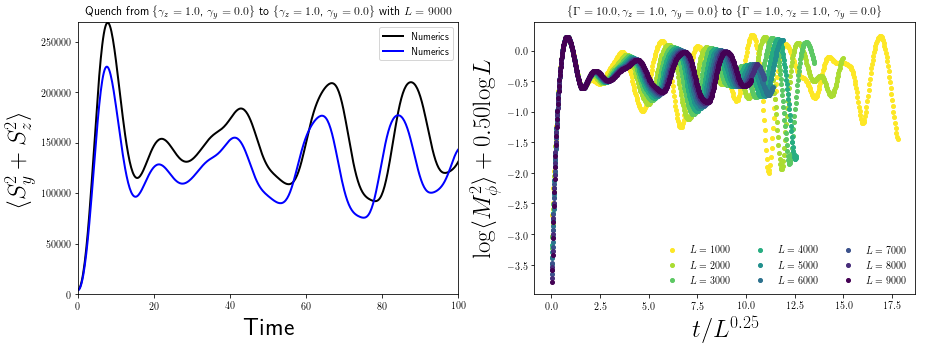

In [38]:
plt.figure(figsize=(15,5))
#plotting
#plt.plot(tarr,Sϕ2vals_nonzero,'-',color='blue',linewidth=2,label='$\\langle S_z^2(t)+ S_y^2(t)\\rangle$')
plt.subplot(1,2,1)
plt.plot(tarr,Sϕ2vals_nonzero[:,-1],'-',color='black',linewidth=2,label='Numerics')#'$\\langle S_z^2(t)\\rangle$')
plt.plot(tarr,Sϕ2vals_nonzero[:,-2],'-',color='blue',linewidth=2,label='Numerics')
#plt.plot(tarr,Sy2vals_nonzero,'-',color='red',linewidth=2,label='$\\langle S_y^2(t)\\rangle$')
#plt.plot(np.linspace(0,Tf,1000),Szt,color='blue',label='Holstein-Primakoff',linewidth=1.5)
#plt.axhline(Sz2inf,linestyle='dashed',color= 'black',label='$t=\\infty$ avg',linewidth=2)
plt.xlabel("Time",fontsize=25)
plt.ylabel("$\\langle S_y^2+S_z^2\\rangle$",fontsize=25)#"+S_y^2\\rangle$",fontsize=25)
plt.xlim(0,tarr[-1])
plt.ylim(0,np.max(Sϕ2vals_nonzero[:,-1])+100)
plt.legend(numpoints=1,loc=1)#bbox_to_anchor=(1.5,1))
plt.title('Quench from \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} to \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} with $L=%d$'%(paramvals0.γz,paramvals0.γy, paramvalsf.γz,paramvalsf.γy,L))
#figcaption("Time-dependence of the total spin for a system size $L=1000$ with the quench parameters shown in the figure. ")
plt.subplot(1,2,2)
mϕ=0.50
mt=0.25
cmap=plt.cm.get_cmap('viridis_r')
stLind=0
colors = cmap(np.linspace(0,1,np.size(Larr_nonzero[stLind:])))
for L,p in zip(Larr_nonzero[stLind:],range(stLind,stLind+np.size(Larr_nonzero[stLind:]))):
    #print(p)
    plt.plot(tarr/L**mt,np.log(Mϕ2vals_nonzero[:,p])+mϕ*np.log(L),'.',color=colors[p-stLind],markersize=8,linewidth=2,label='$L=%d$'% L)
plt.xlabel("$t/L^{ %0.2f } $"% mt,fontsize=25)
plt.ylabel("${\\rm log}\\langle M^2_\\phi \\rangle+ %0.2f {\\rm log}L$"% mϕ,fontsize=25)
plt.legend(loc=4,numpoints=1,ncol=3,frameon=False)
#plt.ylim((-0.3,0.5))
plt.title(' \\{$\Gamma=%.1f, \\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} to \\{$\\Gamma=%.1f, \\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\}'%(paramvals0.Γ,paramvals0.γz,paramvals0.γy, paramvalsf.Γ,paramvalsf.γz,paramvalsf.γy))


In [75]:
correlationmat=LMG.twotimecorrelation(paramvals0,t1arr,t2arr,GState,energyf,vecf,Azf,Ayf)

In [64]:
#calculate or load two time correlation <Sϕ(t2)Sϕ(t1)>
correlationmat=LMG.twotimecorrelation(paramvals0,t1arr,t2arr,GState,energyf,vecf,Azf,Ayf)
LMG.save_data_twotimecorrelation(paramvals0,paramvalsf,correlationmat,t1arr,t2arr,Azf,Ayf)

data/Twotimecorrelation/Twotimecorrelator_Az_1.0_Ay_0.0_t1_[20.0_0.0_20.0]_t2_[10.0_1.0_50.0]_from_L_3000,S_1500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0_to_L_3000,S_1500.0,J_1.0,Γ_1.0,γz_0.0,γy_1.0.hdf5


In [77]:
directory1='data/Twotimecorrelation/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Twotimecorrelation/'
directory5='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/data/Twotimecorrelation/'
L=3000
paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=0.,γy=1.,Γ=1.)
filename1=directory5+'Twotimecorrelator_Az_1.0_Ay_0.0_t1_'+LMG.arrtostr(t1arr)+'_t2_'+LMG.arrtostr(t2arr)+'_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
print(filename1)
with h5py.File(filename1, "r") as f:
    correlationzarr= f["correlationarr"][...]
np.shape(correlationzarr)

/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/data/Twotimecorrelation/Twotimecorrelator_Az_1.0_Ay_0.0_t1_[20.0_0.0_20.0]_t2_[10.0_1.0_50.0]_from_L_3000,S_1500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0_to_L_3000,S_1500.0,J_1.0,Γ_1.0,γz_0.0,γy_1.0.hdf5


(1, 41)

In [45]:
print(filename1)

/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/data/Twotimecorrelation/Twotimecorrelator_Az_1.0_Ay_0.0_t1_[20.0_0.0_20.0]_t2_[0.0_1.0_10.0]_from_L_9000,S_4500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0_to_L_9000,S_4500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0.hdf5


In [555]:
#load two time correlation <Sϕ(t2)Sϕ(t1)> from file
directory1='data/Twotimecorrelation/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Twotimecorrelation/'
directory5='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/data/Twotimecorrelation/'
correlationyvals=np.zeros((np.size(t2arr),np.size(Larr)),dtype=complex)
correlationzvals=np.zeros((np.size(t2arr),np.size(Larr)),dtype=complex)
deletelist=np.array([],dtype=int)
for L,p in zip(Larr,range(np.size(Larr))):
    #print('L='+str(L))#, end='\r', flush=True)
    paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
    paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=0.,γy=1.,Γ=1.)
    #load Sz^2 data
    filename1=directory5+'Twotimecorrelator_Az_1.0_Ay_0.0_t1_'+LMG.arrtostr(t1arr)+'_t2_'+LMG.arrtostr(t2arr)+'_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    #load Sy^2 data
    filename2=directory5+'Twotimecorrelator_Az_0.0_Ay_1.0_t1_'+LMG.arrtostr(t1arr)+'_t2_'+LMG.arrtostr(t2arr)+'_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    #print(filename1)
    if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
        print("L="+str(L)+" data doesn't exist!")
        deletelist=np.append(deletelist,int(p))
    else:
        #print("Loading files:\n "+filename1+"\n"+filename2)
        with h5py.File(filename1, "r") as f:
            correlationzarr= f["correlationarr"][...]
        with h5py.File(filename2, "r") as f:
            correlationyarr= f["correlationarr"][...]
        correlationzvals[:,p]=correlationzarr
        correlationyvals[:,p]=correlationyarr
correlationzvals_nonzero=np.delete(correlationzvals,deletelist,axis=1)
correlationyvals_nonzero=np.delete(correlationyvals,deletelist,axis=1)
Larr_nonzero2=np.delete(Larr,deletelist,axis=0)

L=800 data doesn't exist!
L=2000 data doesn't exist!
L=6000 data doesn't exist!
L=7000 data doesn't exist!
L=8000 data doesn't exist!
L=9000 data doesn't exist!


In [104]:
#Analytical formula  for non-critical to non-critical quench
ω0t=np.sqrt((paramvals0.Γ-paramvals0.J*paramvals0.γz)/(paramvals0.Γ-paramvals0.J*paramvals0.γy))
ωt=np.sqrt((paramvalsf.Γ-paramvalsf.J*paramvalsf.γz)/(paramvalsf.Γ-paramvalsf.J*paramvalsf.γy))
ω=2*np.sqrt((paramvalsf.Γ-paramvalsf.J*paramvalsf.γz)*(paramvalsf.Γ-paramvalsf.J*paramvalsf.γy))
ω0=2*np.sqrt((paramvals0.Γ-paramvals0.J*paramvals0.γz)*(paramvals0.Γ-paramvals0.J*paramvals0.γy))
print([ω0t,ωt,ω,ω0])
analytic_mag=L/2*(1/4*(1/ω0t+ω0t/ωt**2)+1/4*(1/ω0t-ω0t/ωt**2)*np.cos(2*ω*t2arr))
analytic_correlation_real=(L/2)*(1/(4*ω0t))*(1+(ω0t/ωt)**2)*np.cos(ω*(t2arr-t1arr[0]))+(L/2)*(1/(4*ω0t))*(1-(ω0t/ωt)**2)*np.cos(ω*(t2arr+t1arr[0]))
analytic_correlation_imag=-2*(L/2)*(1/(ω))*np.sin(ω*(t2arr-t1arr[0]))

[0.0, 0.0, 0.0, 0.0]


/home/paraj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/home/paraj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/home/paraj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/paraj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/paraj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/home/paraj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


In [90]:
Larr_nonzero[]

array([4000])

Text(0.5, 0.98, 'Quench from \\{$\\gamma_z= 1.0 $, $\\gamma_{y}= 0.0 $, $\\Gamma=1.0 $\\} to \\{$\\gamma_z= 0.0 $, $\\gamma_{y}= 1.0 $, $\\Gamma=1.0 $\\} for $L=4000$')

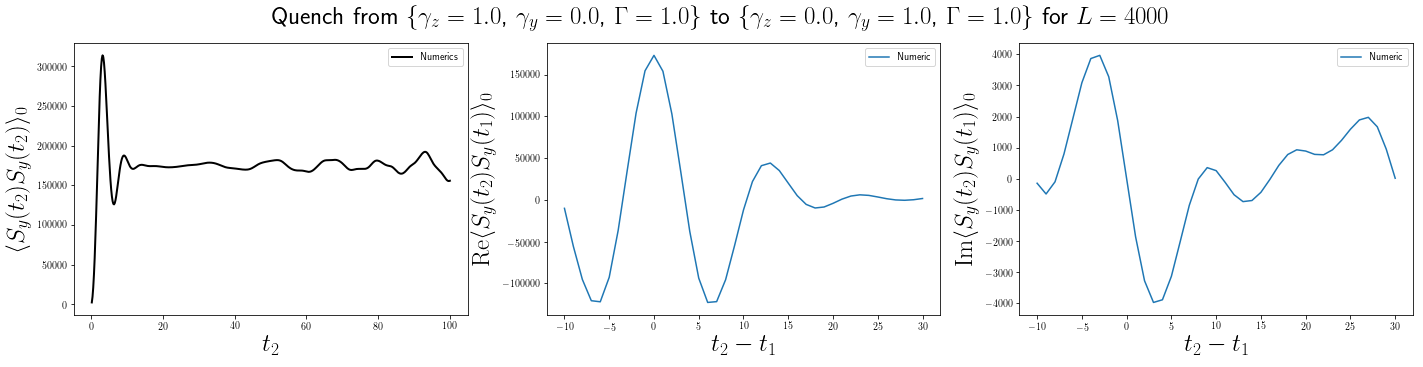

In [103]:
#plotting time dependence
plt.figure(figsize=[24,5])
plt.subplot(1,3,1)
plt.plot(tarr,Sy2vals_nonzero[:,Larr_nonzero==Larr_nonzero2[-1]],'-',color='black',linewidth=2,label='Numerics')#'$\\langle S_z^2(t)\\rangle$')
#plt.plot(t2arr,np.real(magnetizationmat),'o',label='Magnetization')
#plt.plot(t2arr,analytic_mag,label='Analytic')
plt.xlabel('$t_2$',fontsize=25)
plt.ylabel('$\\langle S_y(t_2)S_y(t_2)\\rangle_0$',fontsize=25)
plt.legend()
plt.subplot(1,3,2)
plt.plot(t2arr-t1arr[0],np.real(correlationyvals_nonzero[:,-1]),'-',label='Numeric')
#plt.plot(t2arr-t1arr[0],analytic_correlation_real,label='Analytic')
plt.xlabel('$t_2-t_1$',fontsize=25)
plt.ylabel('${\\rm Re}\\langle S_y(t_2)S_y(t_1)\\rangle_0$',fontsize=25)
plt.legend()
plt.subplot(1,3,3)
plt.plot(t2arr-t1arr[0],np.imag(correlationyvals_nonzero[:,-1]),'-',label='Numeric')
#plt.plot(t2arr-t1arr[0],analytic_correlation_imag,label='Analytic')
plt.xlabel('$t_2-t_1$',fontsize=25)
plt.ylabel('${\\rm Im}\\langle S_y(t_2)S_y(t_1)\\rangle_0$',fontsize=25)
plt.legend()#bbox_to_anchor=(1.95,0.5),fontsize=25)
plt.suptitle('Quench from \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $, $\Gamma=%.1f $\\} to \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $, $\Gamma=%.1f $\\} for $L=%d$'%(paramvals0.γz,paramvals0.γy,paramvals0.Γ, paramvalsf.γz,paramvalsf.γy,paramvalsf.Γ,Larr_nonzero2[-1]),fontsize=25)


Text(0.5, 0.98, 'Quench from \\{$\\gamma_z= 1.0 $, $\\gamma_{y}= 0.0 $, $\\Gamma=1.0 $\\} to \\{$\\gamma_z= 0.0 $, $\\gamma_{y}= 1.0 $, $\\Gamma=1.0 $\\}')

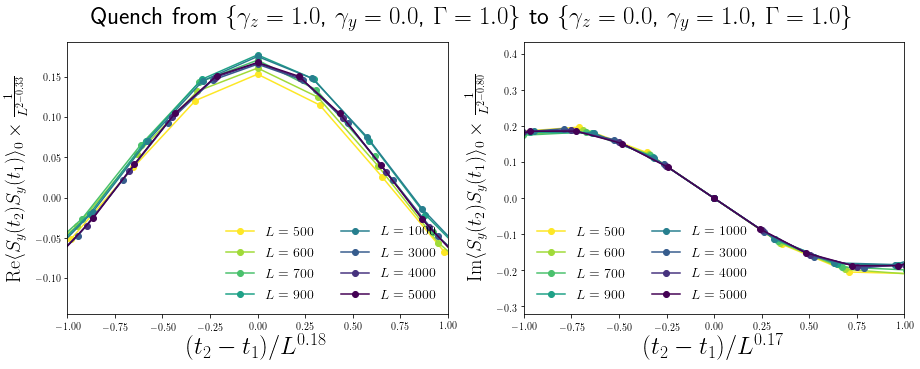

In [564]:
## Use for calculating <Sϕ(t2)Sϕ(t1)> as a function of t2-t1

stLind=4 #plots for L values in Larr[stLind:]
#colormap
cmap=plt.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,np.size(Larr_nonzero2[stLind:])))
#finite size scaling collapse
mtR=0.18#1/3#0.17
mzR=0.33#2/3#0.33
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
for L,p in zip(Larr_nonzero2[stLind:],range(stLind,np.size(Larr_nonzero2))):
    #print(p)
    plt.plot((t2arr-t1arr[0])/L**mtR,(np.real(correlationyvals_nonzero[:,p]))/L**(2-mzR),'-o',color=colors[p-stLind],label='$L=%d$'% L)
#plt.plot(t2arr-t1arr[0],analytic_correlation_real,label='Analytic')
plt.xlabel('$(t_2-t_1)/L^{%.2f}$'% mtR,fontsize=25)
plt.ylabel('${\\rm Re}\\langle S_y(t_2)S_y(t_1)\\rangle_0\\times\\frac{1}{L^{2-%.2f}}$'%mzR,fontsize=20)
plt.xlim(-1,1)
#plt.ylim (-0.05,0.05)
plt.legend(fontsize=14,frameon=False,loc=4,ncol=2)
plt.subplot(1,2,2)
mtI=1/6.#1/3#1/6
mzI=0.8#2/3
for L,p in zip(Larr_nonzero2[stLind:],range(stLind,np.size(Larr_nonzero2))):
    #print(p)
    plt.plot((t2arr-t1arr[0])/L**mtI,(np.imag(correlationyvals_nonzero[:,p]))/L**(2-mzI),'-o',color=colors[p-stLind],label='$L=%d$'% L)
#plt.plot(t2arr-t1arr[0],analytic_correlation_real,label='Analytic')
plt.xlabel('$(t_2-t_1)/L^{%.2f}$'% mtI,fontsize=25)
plt.ylabel('${\\rm Im}\\langle S_y(t_2)S_y(t_1)\\rangle_0\\times\\frac{1}{L^{2-%.2f}}$'%mzI,fontsize=20)
plt.xlim(-1,1)
#plt.ylim(-0.05,0.05)
plt.legend(fontsize=14,frameon=False,loc=3,ncol=2)
plt.suptitle('Quench from \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $, $\Gamma=%.1f $\\} to \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $, $\Gamma=%.1f $\\}'%(paramvals0.γz,paramvals0.γy,paramvals0.Γ, paramvalsf.γz,paramvalsf.γy,paramvalsf.Γ),fontsize=25)

#save figure
#Az=0.
#Ay=1.
#figname='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/plots/Twotimecorrelation_scalingLt1t2_Az_'+str(float(Az))+'_Ay_'+str(float(Ay))+'_t1_'+LMG.arrtostr(t1arr)+'_t2_'+LMG.arrtostr(t2arr)+'_from_'+paramvals0.paramstrwithoutLS()+'_to_'+paramvalsf.paramstrwithoutLS()+'.pdf'
#print(figname)
#plt.savefig(figname,bbox_inches="tight")

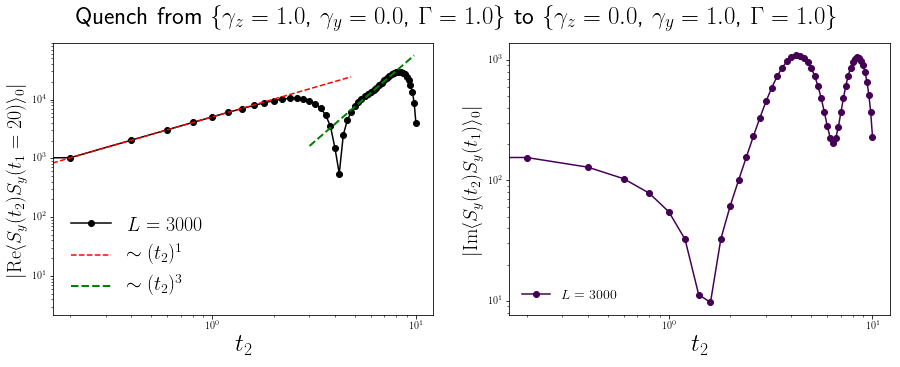

In [174]:
## Use for calculating <Sϕ(t2)Sϕ(t1)> as a function of t2 for fixed t1 for largest system size

stLind=-1 #plots for L values in Larr[stLind:]
#colormap
cmap=plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0,1,np.size(Larr_nonzero2[stLind:])))
#finite size scaling collapse
mtR=0.17#1/3#0.17
mzR=0.33#2/3#0.33
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
for L,p in zip(Larr_nonzero2[stLind:],range(stLind,np.size(Larr_nonzero2))):
    #print(p)
    plt.loglog((t2arr),(np.abs(np.real(correlationyvals_nonzero[:,p]))),'-o',color='black',label='$L=%d$'% L)
    plt.loglog((t2arr[0:25]),(np.abs(np.real(correlationyvals_nonzero[5,p])))*t2arr[0:25]**1,'--',color='red',label='$\\sim (t_2)^1 $')
    plt.loglog((t2arr[15:50]),(60)*t2arr[15:50]**3,'--',color='green',linewidth=2,label='$\\sim (t_2)^3 $')

#plt.plot(t2arr-t1arr[0],analytic_correlation_real,label='Analytic')
plt.xlabel('$t_2$',fontsize=25)
plt.ylabel('$|{\\rm Re}\\langle S_y(t_2)S_y(t_1=20)\\rangle_0|$',fontsize=20)
#plt.xlim(-2,4)
#plt.ylim (-0.05,0.05)
plt.legend(fontsize=20,frameon=False,loc=3)
plt.subplot(1,2,2)
mtI=0.0#1/3#1/6
mzI=1.4#2/3
for L,p in zip(Larr_nonzero2[stLind:],range(stLind,np.size(Larr_nonzero2))):
    #print(p)
    plt.loglog(t2arr,np.abs(np.imag(correlationyvals_nonzero[:,p])),'-o',color=colors[p-stLind],label='$L=%d$'% L)
#plt.plot(t2arr-t1arr[0],analytic_correlation_real,label='Analytic')
plt.xlabel('$t_2$',fontsize=25)
plt.ylabel('$|{\\rm Im}\\langle S_y(t_2)S_y(t_1)\\rangle_0|$',fontsize=20)
#plt.xlim(-2,4)
#plt.ylim(-0.05,0.05)
plt.legend(fontsize=14,frameon=False,loc=3,ncol=2)
plt.suptitle('Quench from \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $, $\Gamma=%.1f $\\} to \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $, $\Gamma=%.1f $\\}'%(paramvals0.γz,paramvals0.γy,paramvals0.Γ, paramvalsf.γz,paramvalsf.γy,paramvalsf.Γ),fontsize=25)

#save figure
Az=0.
Ay=1.
figname='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/plots/Aging_Twotimecorrelation_scalingLt1t2_Az_'+str(float(Az))+'_Ay_'+str(float(Ay))+'_t1_'+LMG.arrtostr(t1arr)+'_t2_'+LMG.arrtostr(t2arr)+'_from_'+paramvals0.paramstrwithoutLS()+'_to_'+paramvalsf.paramstrwithoutLS()+'.pdf'
#print(figname)
plt.savefig(figname,bbox_inches="tight")

# Effective temperature from two time correlation

Here we obtain the effective temperature from the two time correlation for a particular quench

In [46]:
#two-time correlator definitions
Larr=[700,900,1000,2000,3000]#,4000]#np.concatenate([np.arange(100,1100,100),np.arange(2000,10000,1000)])
t1arrtype=[np.array([15.]),np.array([20.])]# t1arr for type 1 and type III
t2arr=np.linspace(15,25,int((25-15)/0.1)+1)#np.linspace(10,50,int((50-10)/1.0)+1)#np.linspace(0,10,int((10-0)/0.2)+1)
Azf=1.
Ayf=0.
#Types of quenches I,III indexed by typeID 0,1 and 2 respectively
initparams=np.array([[1.,0.,4.],[0.,1.,1.]])#{γz,γy,Γ}, and rows indicated type
quenchparams=np.array([[1.,0.,1.],[1.,0.,1.]])

In [47]:
#load two time correlation <Sϕ(t2)Sϕ(t1)> from file
directory1='data/Twotimecorrelation/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/'
directory5='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/'
correlationyvals=np.zeros((np.size(t2arr),np.size(Larr),2),dtype=complex)
correlationzvals=np.zeros((np.size(t2arr),np.size(Larr),2),dtype=complex)
deletelist=np.array([],dtype=int)
for typeID in range(1,2):
    for L,p in zip(Larr,range(np.size(Larr))):
        #print('L='+str(L))#, end='\r', flush=True)
        paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=initparams[typeID,0],γy=initparams[typeID,1],Γ=initparams[typeID,2])
        paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=quenchparams[typeID,0],γy=quenchparams[typeID,1],Γ=quenchparams[typeID,2])
        t1arr=t1arrtype[typeID]
        #load Sz^2 data
        filename1=directory2+'data/Twotimecorrelation/Twotimecorrelator_Az_1.0_Ay_0.0_t1_'+LMG.arrtostr(t1arr)+'_t2_'+LMG.arrtostr(t2arr)+'_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
        #load Sy^2 data
        filename2=directory2+'data/Twotimecorrelation/Twotimecorrelator_Az_0.0_Ay_1.0_t1_'+LMG.arrtostr(t1arr)+'_t2_'+LMG.arrtostr(t2arr)+'_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
        #print(filename1)
        if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
            print("L="+str(L)+" data doesn't exist!")
            deletelist=np.append(deletelist,int(p))
        else:
            #print("Loading files:\n "+filename1+"\n"+filename2)
            with h5py.File(filename1, "r") as f:
                correlationzarr= f["correlationarr"][...]
            with h5py.File(filename2, "r") as f:
                correlationyarr= f["correlationarr"][...]
            correlationzvals[:,p,typeID]=correlationzarr
            correlationyvals[:,p,typeID]=correlationyarr

L=700 data doesn't exist!
L=900 data doesn't exist!
L=1000 data doesn't exist!
L=2000 data doesn't exist!
L=3000 data doesn't exist!


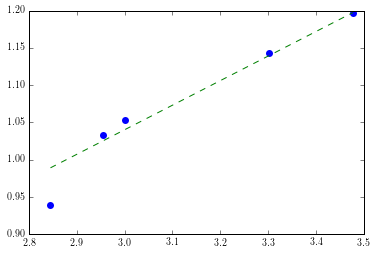

In [53]:
######################type III####################
typeID=1
t1arr=t1arrtype[typeID]
Δt=0.1 #seems to be the case on the time-data t2arr-t1arr[0]
dGdtvals=np.diff(np.real(correlationzvals),axis=0)/Δt
χvals=np.imag(correlationzvals)
effectiveTemp3=np.squeeze(np.sum(dGdtvals[50:,:,1],axis=0))/np.squeeze(np.sum(χvals[50:,:,1],axis=0))
plt.plot(np.log10(Larr),np.log10(effectiveTemp3),'o',markersize=7,markeredgewidth=0,label='$Numerics$')
plt.plot(np.log10(Larr),0.05+0.33*np.log10(Larr),'--',markersize=7,markeredgewidth=0,label='$\\textrm{Fit}\sim N^{1/3}$')

#ax2.set_xlabel('$(t_2-t_1)/N^{0.17}$',fontsize=25)
#ax2.set_ylabel('${\\rm Re}\{\\langle S_z(t_2)S_z(t_1)\\rangle\}/N^{1+0.65}$',fontsize=25,labelpad=-10)

In [20]:
np.diff((t2arr-t1arr[0]))

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

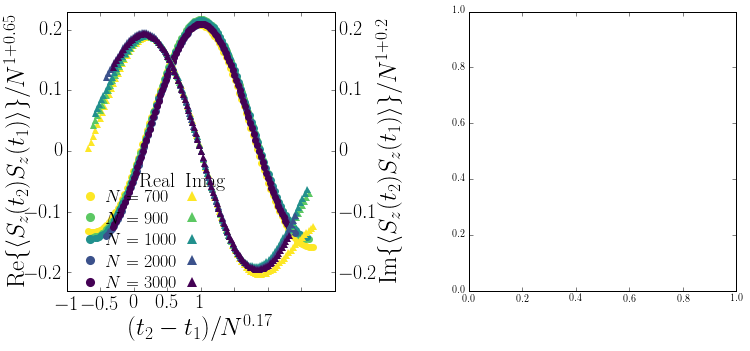

In [12]:

#colormap
cmap=plt.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,np.size(Larr)))

mzRvals=[1./2.,0.64]
mtRvals=[1./4.,1./6.]
mzIvals=[1./2.,0.2]
mtIvals=[1./4.,1./6.]
fig, (ax2,ax1) = plt.subplots(1,2,figsize=(12,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
######################type III####################
typeID=1
t1arr=t1arrtype[typeID]
#finite size scaling collapse
for L,p in zip(Larr,range(np.size(Larr))):
    #print(p)
    ax2.plot((t2arr-t1arr[0])/L**mtRvals[typeID],(np.real(correlationzvals[:,p,typeID]))/L**(1+mzRvals[typeID]),'o',color=colors[p],markersize=7,markeredgewidth=0,label='$N=%d$'% L)
ax2.set_xlabel('$(t_2-t_1)/N^{0.17}$',fontsize=25)
ax2.set_ylabel('${\\rm Re}\{\\langle S_z(t_2)S_z(t_1)\\rangle\}/N^{1+0.65}$',fontsize=25,labelpad=-10)
ax2.set_xlim(-10,10)
ax2.set_xticklabels(['$-1$','$-0.5$','$0$','$0.5$','$1$'],fontsize=20)
ax2.set_ylim(-0.23,0.23)
ax2.set_yticks([-0.2,-0.1,0,0.1,0.2])
ax2.set_yticklabels(['$-0.2$','$-0.1$','$0$','$0.1$','$0.2$'],fontsize=20)
ax2I = ax2.twinx()
for L,p in zip(Larr,range(np.size(Larr))):
    #print(p)
    ax2I.plot((t2arr-t1arr[0])/L**mtIvals[typeID],(np.imag(correlationzvals[:,p,typeID]))/L**(1+mzIvals[typeID]),'^',color=colors[p],markersize=7,markeredgewidth=0,label='  ')#'$N=%d$'% L)
ax2I.set_xlabel('$(t_2-t_1)/N^{0.17}$',fontsize=25)
ax2I.set_ylabel('${\\rm Im}\{\\langle S_z(t_2)S_z(t_1)\\rangle\}/N^{1+0.2}$',fontsize=25,labelpad=1)
ax2I.set_xlim(-2,2)
ax2I.set_ylim(-0.23,0.23)
#ax2I.set_ylim(-0.1,0.1)
ax2I.set_yticks([-0.2,-0.1,0,0.1,0.2])
ax2I.set_yticklabels(['$-0.2$','$-0.1$','$0$','$0.1$','$0.2$'],fontsize=20)
#legends
ax2.legend(fontsize=18,frameon=False,bbox_to_anchor=(0.47,0.42),ncol=1,numpoints=1,handlelength=1,markerscale=1.3,columnspacing=0.5,labelspacing=0.3,handletextpad=0.3)
ax2I.legend(fontsize=18,frameon=False,bbox_to_anchor=(0.64,0.42),ncol=1,numpoints=1,handlelength=1,markerscale=1.3,columnspacing=0.5,labelspacing=0.3,handletextpad=1.2)
ax2.text(-0.91,-0.06,"${\\rm Real}$",fontsize=20)
#ax2.text(-0.82,-0.065,"$\overbrace{\\hspace{0.1in}}$",fontsize=20)
ax2.text(-0.23,-0.06,"${\\rm Imag}$",fontsize=20)
#ax2.text(-0.22,-0.065,"$\overbrace{\\hspace{0.1in}}$",fontsize=20)

## Two-time correlators : Finite temperature properties

In this section, we will exclusively focus on the case $\gamma_y=0$.

Look at the following
\begin{itemize}
\item $\langle S^\dagger_z(t_1)S_z(t_1)\rangle_\beta$ as a function of time to ensure we have a steady state.
\item $\langle S^\dagger_z(t_1)S_z(t_2)\rangle_\beta$ as a function of $t_2-t_1$
\end{itemize}

In [28]:
Larr=np.concatenate([[20],np.arange(100,500,100)])#,np.arange(1000,2000,1000)])
L=20
paramvals=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=0.7)
Az=1.
Ay=0.
t1arr=np.array([20.])
t2arr=np.linspace(10,50,int((50-10)/1.0)+1)#np.linspace(0.,t1,40)
β=LMG.finitetemp_criticalβ(paramvals)
print("Critical temperature="+str(1/β))

Critical temperature=0.80710201095


In [25]:
#Check 1
#compare finite temp two time correlation at same time vs finite temp magnetization.
print(LMG.finitetemp_twotimecorrelation(paramvals,np.array([0]),np.array([0]),β,Az,Ay)*4/L**2)
print(LMG.Finitetempmagnetizationϕ2(paramvals,β,Az,Ay))

[[ 0.04821954+0.j]]
0.0482195424172


In [20]:
#Check 2
# compare 'zero temperature' result with finite tempereature result with β->inf
#finite temperature result
β=10000
t1arr=np.array([20.])
t2arr=np.array([30.])#np.linspace(10,50,int((50-10)/1.0)+1)
paramvals=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=0.8)
print(LMG.finitetemp_twotimecorrelation(paramvals,t1arr,t2arr,β,Az,Ay))

Hamquench=LMG.LMG_generateHam(paramvals)
energyf,vecf=LA.eig(Hamquench)
idx = energyf.argsort()
energyf = energyf[idx]
vecf = vecf[:,idx]
GState=vecf[:,0]
print(LMG.twotimecorrelation(paramvals,t1arr,t2arr,GState,energyf,vecf,Az,Ay))

[[ 825.53753483+23.15472941j]]
[[ 825.62139831+23.09902194j]]


In [20]:
#Test saving data
finitetempcorr=LMG.finitetemp_twotimecorrelation(paramvals,t1arr,t2arr,β,Az,Ay)
LMG.save_data_finitetemp_twotimecorrelation(β,paramvals,finitetempcorr,t1arr,t2arr,Az,Ay)

data/FiniteTempTwotimecorrelation/FiniteTempTwotimecorrelator_β_1.23900075385_Az_1.0_Ay_0.0_t1_[20.0_0.0_20.0]_t2_[10.0_1.0_50.0]_from_L_20,S_10.0,J_1.0,Γ_0.7,γz_1.0,γy_0.0.hdf5


In [29]:
#load file and check data
directory1='/home/parajtitum/LMG_quench/data/FiniteTempTwotimecorrelation/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/FiniteTempTwotimecorrelation'
directory5='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/data/FiniteTempTwotimecorrelation/'
correlationvals=np.zeros((np.size(t2arr),np.size(Larr)),dtype=complex)
deletelist=np.array([],dtype=int)
for L,p in zip(Larr,range(np.size(Larr))):
    #print('L='+str(L))#, end='\r', flush=True)
    paramvals=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=0.7)
    #load Sz^2 data
    filename1=directory5+'FiniteTempTwotimecorrelator_β_'+str(β)+'_Az_'+str(float(Az))+'_Ay_'+str(float(Ay))+'_t1_'+LMG.arrtostr(t1arr)+'_t2_'+LMG.arrtostr(t2arr)+'_from_'+paramvals.paramstr()+'.hdf5'    
    #print(filename1)
    if (not os.path.exists(filename1)):
        print("L="+str(L)+" data doesn't exist!")
        deletelist=np.append(deletelist,int(p))
    else:
        #print("Loading files:\n "+filename1+"\n"+filename2)
        with h5py.File(filename1, "r") as f:
            correlationarr= f["correlationarr"][...]
        correlationvals[:,p]=correlationarr
correlationvals_nonzero=np.delete(correlationvals,deletelist,axis=1)
Larr_nonzero2=np.delete(Larr,deletelist,axis=0)

L=300 data doesn't exist!
L=400 data doesn't exist!


/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/plots/Twotimecorrelation_finitetemp_β_1.23900075385_scalingLt1t2_Az_1.0_Ay_0.0_t1_[20.0_0.0_20.0]_t2_[10.0_1.0_50.0]_from_J_1.0,Γ_0.7,γz_1.0,γy_0.0.pdf


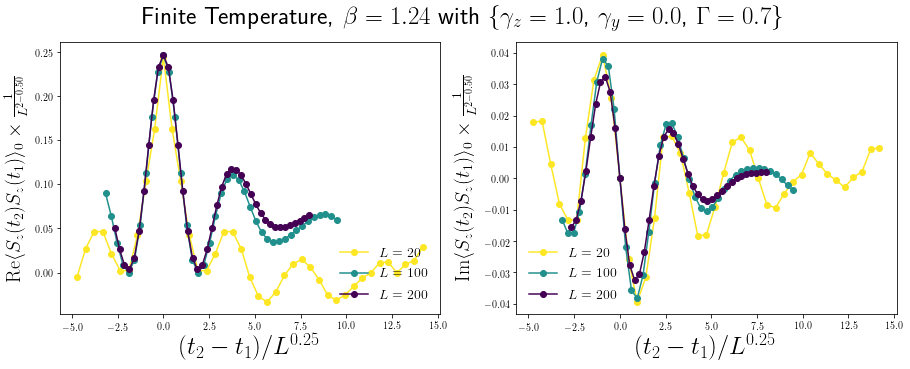

In [41]:
stLind=0 #plots for L values in Larr[stLind:]
#colormap
cmap=plt.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,np.size(Larr_nonzero2[stLind:])))
#finite size scaling collapse
mtR=1/4#1/3#0.17
mzR=1/2#2/3#0.33
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
for L,p in zip(Larr_nonzero2[stLind:],range(stLind,np.size(Larr_nonzero2))):
    #print(p)
    plt.plot((t2arr-t1arr[0])/L**mtR,(np.real(correlationvals_nonzero[:,p]))/L**(2-mzR),'-o',color=colors[p-stLind],label='$L=%d$'% L)
#plt.plot(t2arr-t1arr[0],analytic_correlation_real,label='Analytic')
plt.xlabel('$(t_2-t_1)/L^{%.2f}$'% mtR,fontsize=25)
plt.ylabel('${\\rm Re}\\langle S_z(t_2)S_z(t_1)\\rangle_0\\times\\frac{1}{L^{2-%.2f}}$'%mzR,fontsize=20)
#plt.xlim(-2,4)
#plt.ylim (-0.16,0.195)
plt.legend(fontsize=14,frameon=False,loc=4)
plt.subplot(1,2,2)
mtI=1/4#1/3#1/6
mzI=1/2#2/3
for L,p in zip(Larr_nonzero2[stLind:],range(stLind,np.size(Larr_nonzero2))):
    #print(p)
    plt.plot((t2arr-t1arr[0])/L**mtI,(np.imag(correlationvals_nonzero[:,p]))/L**(2-mzI),'-o',color=colors[p-stLind],label='$L=%d$'% L)
#plt.plot(t2arr-t1arr[0],analytic_correlation_real,label='Analytic')
plt.xlabel('$(t_2-t_1)/L^{%.2f}$'% mtI,fontsize=25)
plt.ylabel('${\\rm Im}\\langle S_z(t_2)S_z(t_1)\\rangle_0\\times\\frac{1}{L^{2-%.2f}}$'%mzI,fontsize=20)
#plt.xlim(-2,4)
#plt.ylim(-0.3,0.3)
plt.legend(fontsize=14,frameon=False,loc=3)
plt.suptitle('Finite Temperature, $\\beta=%.2f$ with \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $, $\Gamma=%.1f $\\}'%(β,paramvals.γz,paramvals.γy,paramvals.Γ),fontsize=25)
#save figure
#Az=1.
#Ay=0.
figname='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/plots/Twotimecorrelation_finitetemp_β_'+str(β)+'_scalingLt1t2_Az_'+str(float(Az))+'_Ay_'+str(float(Ay))+'_t1_'+LMG.arrtostr(t1arr)+'_t2_'+LMG.arrtostr(t2arr)+'_from_'+paramvals.paramstrwithoutLS()+'.pdf'
print(figname)
plt.savefig(figname,bbox_inches="tight")

In [87]:
#<Sz(t1)Sz(t1)>_β is independent of time so plot as a function of Larr to check thermal result.
magsqβarr=np.zeros(np.size(Larr),dtype=complex)
t1=20
for p in range(np.size(Larr)):
    print(p, end='\r', flush=True)
    L=Larr[p]
    paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γz=1.,γy=0.,Γ=Γsol)
    magsqβarr[p]=finitetemp_twotimecorrelation(paramvals,t1,t1,β,Az,Ay)

/home/paraj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


KeyboardInterrupt: 

/home/paraj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


/usr/lib/python3/dist-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


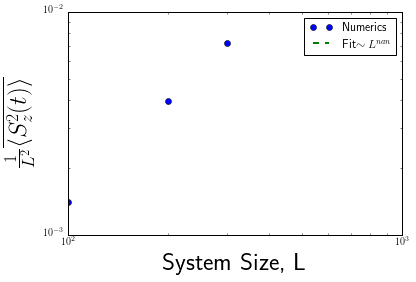

In [90]:
#linear fit to data
logy=np.log10(np.real(magsqβarr))
logx=np.log10(Larr)
m1,b1 = np.polyfit(logx,logy, 1)

plt.figure()
plt.loglog(Larr,np.divide(np.real(magsqβarr),L**2),'o',label='Numerics')
plt.loglog(Larr,(10**b1)*(Larr)**m1,'--',linewidth=2,label='Fit$\\sim L^{%0.2f}$' % m1)
plt.ylabel('$\\frac{1}{L^2}\\overline{\\langle S_z^2(t)\\rangle}$',fontsize=25)
plt.xlabel('System Size, L',fontsize=25)
plt.legend()

In [15]:
#<Sz(t1)Sz(t2)>_β as a function of (t1-t2) 
t1=20.
L=100
paramvals=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=Γsol)
t2arr=np.linspace(0,t1,40)
correlationarr=np.zeros(np.shape(t2arr),dtype=complex)
for t2,p in zip(t2arr,range(np.size(t2arr))):
    print(p, end='\r', flush=True)
    correlationarr[p]=finitetemp_twotimecorrelation(paramvals,t2,t1,β,Az,Ay)

KeyboardInterrupt: 

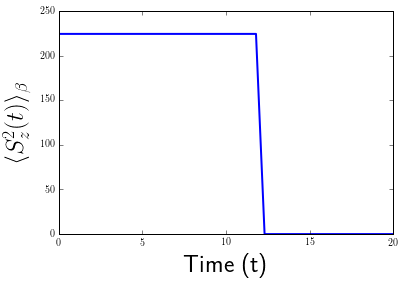

In [85]:
#plot <Sz(t1)Sz(t1)>_β as a function of t1
plt.plot(t1arr,np.real(magsqarr),'-',linewidth=2,label='L=%d'%L)
plt.xlabel("Time (t)",fontsize=25)
plt.ylabel("$\\langle S_z^2(t)\\rangle_\\beta$",fontsize=25)

In [ ]:
magsqβarr=np.zeros(np.size(Larr))
for p in range(np.size(Larr)):
    print(p, end='\r', flush=True)
    L=Larr[p]
    paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γz=1.,γy=0.,Γ=Γsol)
    magsqβarr[p]=finitetemp_twotimecorrelation(paramvals,t1,t1,β,Az,Ay)

In [61]:
np.linspace(0,20,40)

array([ 0.        ,  0.51282051,  1.02564103,  1.53846154,  2.05128205,
        2.56410256,  3.07692308,  3.58974359,  4.1025641 ,  4.61538462,
        5.12820513,  5.64102564,  6.15384615,  6.66666667,  7.17948718,
        7.69230769,  8.20512821,  8.71794872,  9.23076923,  9.74358974,
       10.25641026, 10.76923077, 11.28205128, 11.79487179, 12.30769231,
       12.82051282, 13.33333333, 13.84615385, 14.35897436, 14.87179487,
       15.38461538, 15.8974359 , 16.41025641, 16.92307692, 17.43589744,
       17.94871795, 18.46153846, 18.97435897, 19.48717949, 20.        ])

In [146]:
np.concatenate([np.linspace(10,100,10),np.linspace(200,1000,9)],axis=0)


array([  10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,   90.,
        100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000.])

## Entanglement across a cut

\textbf{Ground state wavefunction properties} 

In [52]:
#parameter definitions
ΔL=10
L=100#np.concatenate([np.arange(100,1000,100),np.arange(1000,2000,1000)])#choose even
part_szarr=np.concatenate([np.linspace(10,100,10)])#,np.linspace(200,1000,9)],axis=0)#np.arange(ΔL,int(L/2)+ΔL,ΔL)


In [9]:
#Get a bunch of Clebsch Gordan matrices (Skip if loading them from files)
if 
for p,part_sz in zip(range(np.size(part_szarr)),part_szarr):
    Stot=L/2
    SA=part_sz/2 #Size of A subsystem
    SB=S-SA #Size of B subsystem
    print((p,SA,SB))#, end='\r', flush=True)
    LMG.CGmatrix_to_file(SA,SB,Stot)

(0, 5.0, 95.0)
Saving to file: data/CGmats/CGmat_SA_5.0_SB_95.0_S_100.0.hdf5
(1, 10.0, 90.0)
(2, 15.0, 85.0)
Saving to file: data/CGmats/CGmat_SA_15.0_SB_85.0_S_100.0.hdf5
(3, 20.0, 80.0)
Saving to file: data/CGmats/CGmat_SA_20.0_SB_80.0_S_100.0.hdf5
(4, 25.0, 75.0)
Saving to file: data/CGmats/CGmat_SA_25.0_SB_75.0_S_100.0.hdf5
(5, 30.0, 70.0)
Saving to file: data/CGmats/CGmat_SA_30.0_SB_70.0_S_100.0.hdf5
(6, 35.0, 65.0)
Saving to file: data/CGmats/CGmat_SA_35.0_SB_65.0_S_100.0.hdf5
(7, 40.0, 60.0)
Saving to file: data/CGmats/CGmat_SA_40.0_SB_60.0_S_100.0.hdf5
(8, 45.0, 55.0)
Saving to file: data/CGmats/CGmat_SA_45.0_SB_55.0_S_100.0.hdf5
(9, 50.0, 50.0)
Saving to file: data/CGmats/CGmat_SA_50.0_SB_50.0_S_100.0.hdf5


In [7]:
directory='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/CGmats/'
#Ground state properties
Γarr=np.linspace(1.,4.,20)
#Entanglement entropy
entropyarr=np.zeros((np.size(part_szarr),np.size(Γarr)))
for q in range(np.size(Γarr)):
    paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.0,Γ=Γarr[q])
    Ham=LMG.LMG_generateHam(paramvals0)
    GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
    GState=vec[:,0]
    for p,part_sz in zip(range(np.size(part_szarr)),part_szarr):
        SA=part_sz/2 #Size of A subsystem
        SB=paramvals0.S-SA #Size of B subsystem
        print(p, end='\r', flush=True)
        cgmat=LMG.CGmatrix(SA,SB,paramvals0.S,directory)
        GStateAB=np.matmul(cgmat,GState)#(2SA+1)(2SB+1)X1 array
        #ρA=LMG.Reduced_ρ(GStateAB,SA,SB)
        #entropyarr[p,q]=LMG.EEntropy_VN(ρA)

KeyboardInterrupt: 

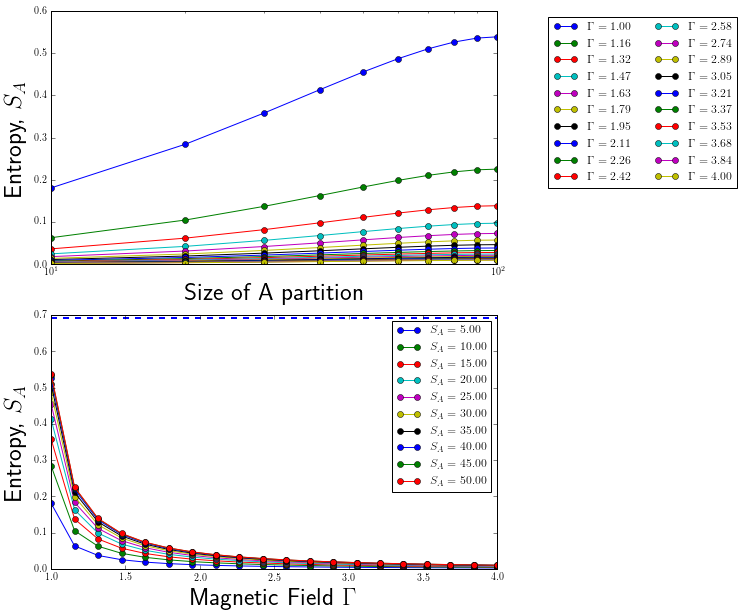

In [70]:
plt.figure(figsize=(8,10))
#plotting entropy in log scale
plt.subplot(2,1,1)
for q in range(np.size(Γarr)):
    plt.semilogx(part_szarr,entropyarr[:,q],'-o',label="$\\Gamma=%0.2f$"%Γarr[q])
plt.legend(bbox_to_anchor=(1.55,1),ncol=2)
plt.xlabel('Size of A partition',fontsize=25)
plt.ylabel('Entropy, $S_A$',fontsize=25)
plt.subplot(2,1,2)
for q in range(np.size(part_szarr)):
    plt.plot(Γarr,entropyarr[q,:],'-o',label="$S_A=%0.2f$"%(part_szarr[q]/2))
plt.axhline(np.log(2),linestyle='dashed',linewidth=2)
plt.legend(loc=1)#bbox_to_anchor=(1.35,1),ncol=1)
plt.xlabel('Magnetic Field $\\Gamma$',fontsize=25)
plt.ylabel('Entropy, $S_A$',fontsize=25)

## Entanglement dynamics across a quench

In [95]:
#parameter definitions
ΔL=10
L=2000#np.concatenate([np.arange(100,1000,100),np.arange(1000,2000,1000)])#choose even
La_arr=np.concatenate([np.linspace(10,100,10),np.linspace(200,1000,9)],axis=0)#np.arange(ΔL,int(L/2)+ΔL,ΔL)
dt=1.
tarr=np.linspace(1,50,int((50-1)/dt)+1)#np.arange(1,50+dt,dt)
Stot=L/2
paramvals0=LMG.Ham_params(N=L,S=Stot,J=1.,γz=1.,γy=0.,Γ=4.)
paramvalsf=LMG.Ham_params(N=L,S=Stot,J=1.,γz=1.0,γy=0.0,Γ=1.)

In [96]:
directory='data/CGmats/'
directory1='data/EE/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/EE/'
filename2=directory1+'EE_LA_['+str(La_arr[0])+'_'+str(La_arr[-1])+']_t_'+LMG.arrtostr(tarr)+'_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
filename1=directory2+'EE_LA_['+str(La_arr[0])+'_'+str(La_arr[-1])+']_t_'+LMG.arrtostr(tarr)+'_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
     
entropyarr=np.zeros((np.size(tarr),np.size(La_arr)))
if not (os.path.exists(filename1) or os.path.exists(filename2)):
    print("Running...")
    Ham=LMG.LMG_generateHam(paramvals0)
    GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
    GState=vec[:,0]
    Hamquench=LMG.LMG_generateHam(paramvalsf)
    energyf,vecf=LA.eig(Hamquench)
    for t,q in zip(tarr,range(np.size(tarr))):
        U_t=LMG.LMG_Ut(t,energyf,vecf)
        ψ_t=np.dot(U_t,GState)
        for p,La in zip(range(np.size(La_arr)),La_arr):
            print([p,q], end='\r', flush=True)
            SA=La/2 #Size of A subsystem
            SB=Stot-SA #Size of B subsystem
            cgmat=LMG.CGmatrix(SA,SB,Stot,directory)
            ψ_tAB=np.matmul(cgmat,ψ_t)
            ρA=LMG.Reduced_ρ(ψ_tAB,SA,SB)
            entropyarr[q,p]=LMG.EEntropy_VN(ρA)
    LMG.save_data_EE(paramvals0,paramvalsf,entropyarr,tarr,GState,La_arr)
elif os.path.exists(filename1):
    print("Loading file: "+filename1)
    with h5py.File(filename1, "r") as f:
        entropyarr= f["entropyarr"][...]
        InitState=f["InitState"][...]
        La_arr=f["La_arr"][...]
elif os.path.exists(filename2):
    print("Loading file: "+filename2)
    with h5py.File(filename1, "r") as f:
        entropyarr= f["entropyarr"][...]
        InitState=f["InitState"][...]
        La_arr=f["La_arr"][...]            

Loading file: /home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/EE/EE_LA_[10.0_1000.0]_t_[1.0_1.0_50.0]_from_L_2000,S_1000.0,J_1.0,Γ_4.0,γz_1.0,γy_0.0_to_L_2000,S_1000.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0.hdf5


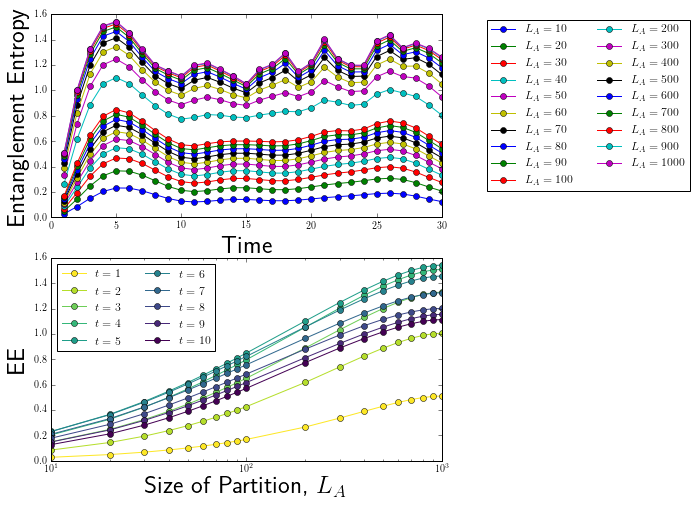

In [97]:
plt.figure(figsize=(7,8))
plt.subplot(2,1,1)
for q in range(np.size(La_arr)):
    plt.plot(tarr,entropyarr[:,q],'-o',label='$L_A=%d$'% La_arr[q])
plt.xlim((0,30))
plt.legend(bbox_to_anchor=(1.65,1),numpoints=1,ncol=2)
plt.ylabel("Entanglement Entropy", fontsize=25)
plt.xlabel("Time",fontsize=25)

#scaling
plt.subplot(2,1,2)
cmap=plt.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,10))#np.size(tarr)))
for q in range(10):#np.size(tarr)):
    plt.semilogx(La_arr,entropyarr[q,:],'-o',color=colors[q],label='$t=%d$'% tarr[q])
#plt.xlim((0,10))
plt.ylabel("EE", fontsize=25)
plt.xlabel("Size of Partition, $L_A$",fontsize=25)
plt.legend(numpoints=1,loc=2,ncol=2)#bbox_to_anchor=(1.65,1.1))

In [24]:
LMG.arrtostr(np.concatenate([np.linspace(10,100,10),np.linspace(200,1000,9)],axis=0))

'[10.0_55.0_1000.0]'

In [7]:
6+34

40

## Overlap between ground state of quench Hamiltonian and initial state
We calculate the overlap for three types of quenches for $L=1000$
\begin{itemize}
\item Type-I:$\{1, 1, 0,4\}\rightarrow\{1,1, 0,1\}$. Overlap,  $\langle\psi^{\rm GS}_0|\psi^{\rm GS}_f\rangle=-0.77$.
\item Type-II:$\{1, 1, 0,1\}\rightarrow\{1,1, 0.5,1\}$. Overlap,  $\langle\psi^{\rm GS}_0|\psi^{\rm GS}_f\rangle=-0.99$. 
\item Type-III:$\{1, 1, 0,1\}\rightarrow\{1,0, 1,1\}$. Overlap,  $\langle\psi^{\rm GS}_0|\psi^{\rm GS}_f\rangle=+0.43$.
\end{itemize}

Note it does have some finite size dependence, but may be it is not so crucial.

In [64]:
L=2000 #Set system size.
paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=4.)
paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1,γy=0,Γ=1.)
dt=0.2 #time step
Tf=20 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)

In [60]:
Ham=LMG.LMG_generateHam(paramvals0)
GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
GState=vec[:,0]
Hamquench=LMG.LMG_generateHam(paramvalsf)
energyf,vecf=spla.eigs(Hamquench,k=2,which="SR")

In [61]:
overlap=np.matmul(np.transpose(np.conjugate(GState)),vecf[:,0])
overlap1=np.matmul(np.transpose(np.conjugate(GState)),vecf[:,1])
print("GState overlap:"+str(overlap))
print("1st Ex State overlap:"+str(overlap1))

GState overlap:(0.741712427952+0j)
1st Ex State overlap:(2.13617360131e-11+0j)


# Full distribution of the observables $S_\phi, S_z, S_y$ etc.
In this section, we examine how the full distribution of observables change as a function of time. It is rather straightforward to calculate the full distriubtion in the z-basis since the Basis states $|S=N/2,M\rangle$ in fact written in the z-basis. 

In [518]:
def Sz_histogram(InitState,U_dt,tarr):
    #Takes an input state, and returns the histogram with probabilities of different Sz values at different times at tarr. Returns two matrices of size [(2S+1) X np.size(tarr)]
    ψ_t=np.copy(InitState)
    histvalues=np.zeros((np.size(ψ_t),np.size(tarr)))
    for t,p in zip(tarr,range(np.size(tarr))):
        print(p, end='\r', flush=True)
        ψ_t=np.dot(U_dt,ψ_t)
        histvalues[:,p]=np.abs(ψ_t)**2
    return histvalues
    

In [521]:
L=4000 #Set system size.
paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=0.,γy=1.,Γ=1.)
paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
dt=0.2 #time step
Tf=100 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)

In [522]:
#simulation
Ham0=LMG.LMG_generateHam(paramvals0)
GSenergy,vec=spla.eigs(Ham0,k=1,which="SR",tol=10**(-6))
InitState=vec[:,0]
print("Obtained Initial State")
Hamf=LMG.LMG_generateHam(paramvalsf)
#energyf,vecf=LA.eig(Hamf)
U_dt=LA.expm(-1j*Hamf*dt)
histvals=Sz_histogram(InitState,U_dt,tarr)

Obtained Initial State


/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/plots/FullDistributionSnapshot_Sz_t_[0.2, 1, 5, 15]_from_L_4000,S_2000.0,J_1.0,Γ_1.0,γz_0.0,γy_1.0_to_L_4000,S_2000.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0.pdf


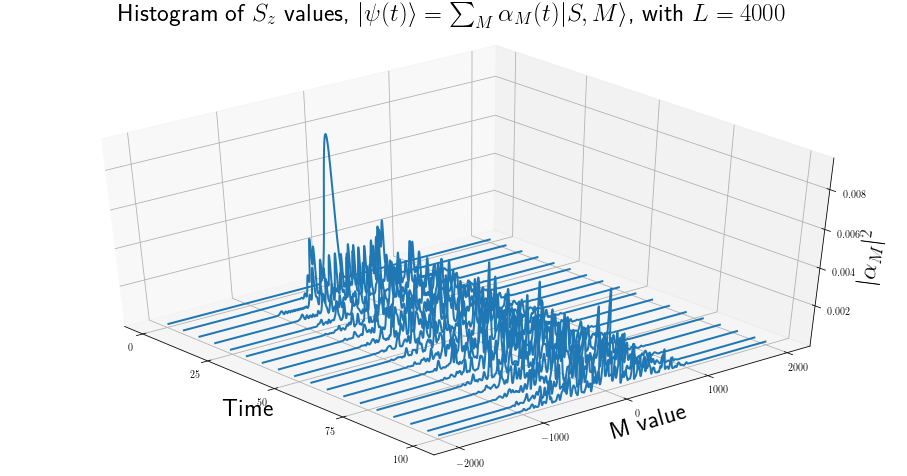

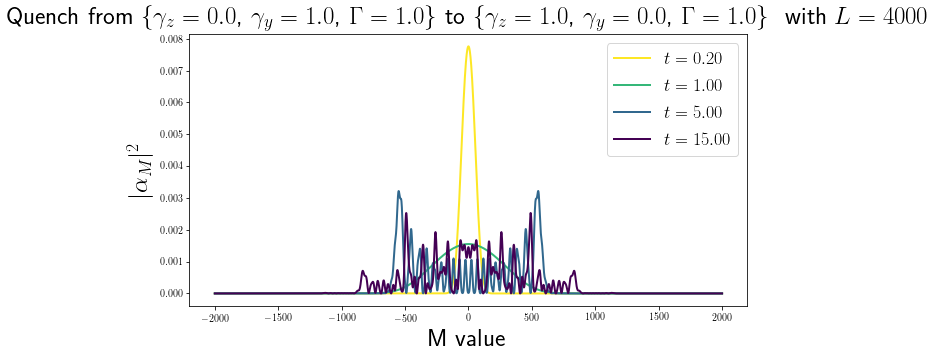

In [540]:
#plot histograms as  a function of time
Marr=np.linspace(-paramvals0.S,paramvals0.S,int(2*paramvals0.S+1))
dtplot=1.
tarr_plot=np.arange(dtplot,Tf+dtplot,dtplot)
tarr_Idlist=[np.where(np.abs(tarr-tarr_plot[p])<10**-6)[0][0] for p in range(np.size(tarr_plot))]
#colormap
#colormap
cmap=plt.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,np.size(tarr_plot)))
#for q in range(np.size(tarr_plot)):
#    plt.plot(Marr,histvals[:,tarr_Idlist[q]],'-o',color=colors[q],label='$t=%d$'% tarr_plot[q])

#surfaceplot
fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(tarr,Marr)
#surf = ax.plot_surface(X,Y,histvals,cmap='viridis_r',linewidth=1)
ax.plot_wireframe(X,Y,histvals,rstride=0, cstride=30,linewidth=2)
ax.view_init(40,-40)
plt.draw()

plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.ylabel("M value",fontsize=25)
plt.xlabel("Time",fontsize=25)
ax.set_zlabel("$|\\alpha_M|^2$",fontsize=25)
plt.title("Histogram of $S_z$ values, $|\\psi(t)\\rangle=\\sum_M\\alpha_M(t)|S,M\\rangle $, with $L=%d$"%L,fontsize=25)
#figname='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/plots/FullDistribution_Sz_t_'+LMG.arrtostr(tarr)+'_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.pdf'
#print(figname)
#plt.savefig(figname,bbox_inches="tight")


##plot snapshot
fig = plt.figure(figsize=(10,5))
tvalarr=[0.2,1,5,15]
cmap=plt.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,np.size(tvalarr)))
for tval,p in zip(tvalarr,range(np.size(tvalarr))):
    tval_Idlist=np.where(np.abs(tarr-tval)<10**-6)[0][0] 
    plt.plot(Marr,histvals[:,tval_Idlist],'-',color=colors[p],label='$t=%.2f$'% tval,linewidth=2)
plt.xlabel("M value",fontsize=25)
plt.ylabel("$|\\alpha_M|^2$",fontsize=25)
plt.legend(loc=1,fontsize=18)
plt.title('Quench from \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $, $\Gamma=%.1f $\\} to \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $, $\Gamma=%.1f$\\} \\ with $L=%d$'%(paramvals0.γz,paramvals0.γy,paramvals0.Γ, paramvalsf.γz,paramvalsf.γy,paramvalsf.Γ,L),fontsize=25)

figname='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/plots/FullDistributionSnapshot_Sz_t_'+str(tvalarr)+'_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.pdf'
print(figname)
plt.savefig(figname,bbox_inches="tight")

# Effective Temperature and properties
In this section we study the effective temperature as obtained from the two time correlation functions.
We examine the relation between the real and imaginary parts of the two time correlation, and look at if there is a particular relation
\begin{equation}
G^R(t)=-\Theta(t)\frac{1}{T_{\rm eff}}\partial G^K(t)
\end{equation}
Looking at the time derivative, the match is almost perfect at large system  sizes. This mean

Alternatively, we can define the effective temperature in the frequency space :
\begin{equation}
T_{\rm eff}=\omega \frac{{\rm Re}\{ \mathcal{C}_{zz}\}(\omega) }{ {\rm Im}\{ \mathcal{C}_{zz}\}(\omega)}
\end{equation}

Two behaviors are apparent by analyzing the Type -III dynamics in the frequency spectrum,
\begin{itemize}
\item Peak at $\omega<1$ corresonding to the frequency of oscillation
\item at $\omega \gg 1$ we see a rather trivial power law decay, where $G^R\sim \frac{1}{\omega}$ and $G^K\sim \frac{1}{\omega^2}$
\item It would be cool to have longer time of evolution, and analyze the more detailed dependence for $\omega <1$
\end{itemize}

In [819]:
#two-time correlator definitions
Larr=[700,900,1000,2000,3000]#,4000]#np.concatenate([np.arange(100,1100,100),np.arange(2000,10000,1000)])
t1arrtype=[np.array([15.]),np.array([20.])]# t1arr for type 1 and type III
t2arr=np.linspace(15,25,int((25-15)/0.1)+1)#np.linspace(10,50,int((50-10)/1.0)+1)#np.linspace(0,10,int((10-0)/0.2)+1)
Azf=1.
Ayf=0.
#Types of quenches I,III indexed by typeID 0,1 and 2 respectively
initparams=np.array([[1.,0.,4.],[0.,1.,1.]])#{γz,γy,Γ}, and rows indicated type
quenchparams=np.array([[1.,0.,1.],[1.,0.,1.]])

In [820]:
#Load two-time correlation data 
#load two time correlation <Sϕ(t2)Sϕ(t1)> from file
directory1='data/Twotimecorrelation/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/'
directory5='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/'
correlationyvals=np.zeros((np.size(t2arr),np.size(Larr),2),dtype=complex)
correlationzvals=np.zeros((np.size(t2arr),np.size(Larr),2),dtype=complex)
deletelist=np.array([],dtype=int)
for typeID in range(1,2):
    for L,p in zip(Larr,range(np.size(Larr))):
        #print('L='+str(L))#, end='\r', flush=True)
        paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=initparams[typeID,0],γy=initparams[typeID,1],Γ=initparams[typeID,2])
        paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=quenchparams[typeID,0],γy=quenchparams[typeID,1],Γ=quenchparams[typeID,2])
        t1arr=t1arrtype[typeID]
        #load Sz^2 data
        filename1=directory5+'data/Twotimecorrelation/Twotimecorrelator_Az_1.0_Ay_0.0_t1_'+LMG.arrtostr(t1arr)+'_t2_'+LMG.arrtostr(t2arr)+'_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
        #load Sy^2 data
        filename2=directory5+'data/Twotimecorrelation/Twotimecorrelator_Az_0.0_Ay_1.0_t1_'+LMG.arrtostr(t1arr)+'_t2_'+LMG.arrtostr(t2arr)+'_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
        #print(filename1)
        if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
            print("L="+str(L)+" data doesn't exist!")
            deletelist=np.append(deletelist,int(p))
        else:
            #print("Loading files:\n "+filename1+"\n"+filename2)
            with h5py.File(filename1, "r") as f:
                correlationzarr= f["correlationarr"][...]
            with h5py.File(filename2, "r") as f:
                correlationyarr= f["correlationarr"][...]
            correlationzvals[:,p,typeID]=correlationzarr
            correlationyvals[:,p,typeID]=correlationyarr

Text(-0.29, -0.075, '$\\overbrace{\\hspace{1in}}$')

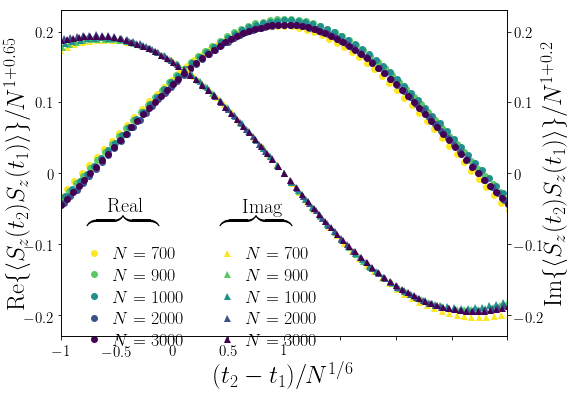

In [582]:
#Scaling collapse for real and imaginary parts of the twotime correlation functions

#colormap
cmap=plt.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,np.size(Larr)))

mzRvals=[1./2.,0.64]
mtRvals=[1./4.,1./6.]
mzIvals=[1./2.,0.2]
mtIvals=[1./4.,1./6.]
fig,ax2=plt.subplots(figsize=(8,6))
######################type III####################
typeID=1
t1arr=t1arrtype[typeID]
#finite size scaling collapse
for L,p in zip(Larr,range(np.size(Larr))):
    #print(p)
    ax2.plot((t2arr-t1arr[0])/L**mtRvals[typeID],(np.real(correlationzvals[:,p,typeID]))/L**(1+mzRvals[typeID]),'o',color=colors[p],markersize=7,markeredgewidth=0,label='$N=%d$'% L)
ax2.set_xlabel('$(t_2-t_1)/N^{1/6}$',fontsize=25)
ax2.set_ylabel('${\\rm Re}\{\\langle S_z(t_2)S_z(t_1)\\rangle\}/N^{1+0.65}$',fontsize=25,labelpad=-10)
ax2.set_xlim(-1,1)
ax2.set_xticklabels(['$-1$','$-0.5$','$0$','$0.5$','$1$'],fontsize=15)
ax2.set_ylim(-0.23,0.23)
ax2.set_yticks([-0.2,-0.1,0,0.1,0.2])
ax2.set_yticklabels(['$-0.2$','$-0.1$','$0$','$0.1$','$0.2$'],fontsize=15)
ax2I = ax2.twinx()
for L,p in zip(Larr,range(np.size(Larr))):
    #print(p)
    ax2I.plot((t2arr-t1arr[0])/L**mtIvals[typeID],(np.imag(correlationzvals[:,p,typeID]))/L**(1+mzIvals[typeID]),'^',color=colors[p],markersize=7,markeredgewidth=0,label='$N=%d$'% L)
ax2I.set_xlabel('$(t_2-t_1)/N^{1/6}$',fontsize=25)
ax2I.set_ylabel('${\\rm Im}\{\\langle S_z(t_2)S_z(t_1)\\rangle\}/N^{1+0.2}$',fontsize=25,labelpad=-1)
ax2I.set_xlim(-1,1)
ax2I.set_ylim(-0.23,0.23)
#ax2I.set_ylim(-0.1,0.1)
ax2I.set_yticks([-0.2,-0.1,0,0.1,0.2])
ax2I.set_yticklabels(['$-0.2$','$-0.1$','$0$','$0.1$','$0.2$'],fontsize=15)
#legends
ax2.legend(fontsize=18,frameon=False,bbox_to_anchor=(0.31,0.33),ncol=1,numpoints=1,handlelength=1,markerscale=1,columnspacing=0.5,labelspacing=0.2,handletextpad=0.5)
ax2I.legend(fontsize=18,frameon=False,bbox_to_anchor=(0.61,0.33),ncol=1,numpoints=1,handlelength=1,markerscale=1,columnspacing=0.5,labelspacing=0.2,handletextpad=0.5)
ax2.text(-0.79,-0.055,"${\\rm Real}$",fontsize=20)
ax2.text(-0.89,-0.075,"$\overbrace{\\hspace{1in}}$",fontsize=20)
ax2.text(-0.19,-0.055,"${\\rm Imag}$",fontsize=20)
ax2.text(-0.29,-0.075,"$\overbrace{\\hspace{1in}}$",fontsize=20)

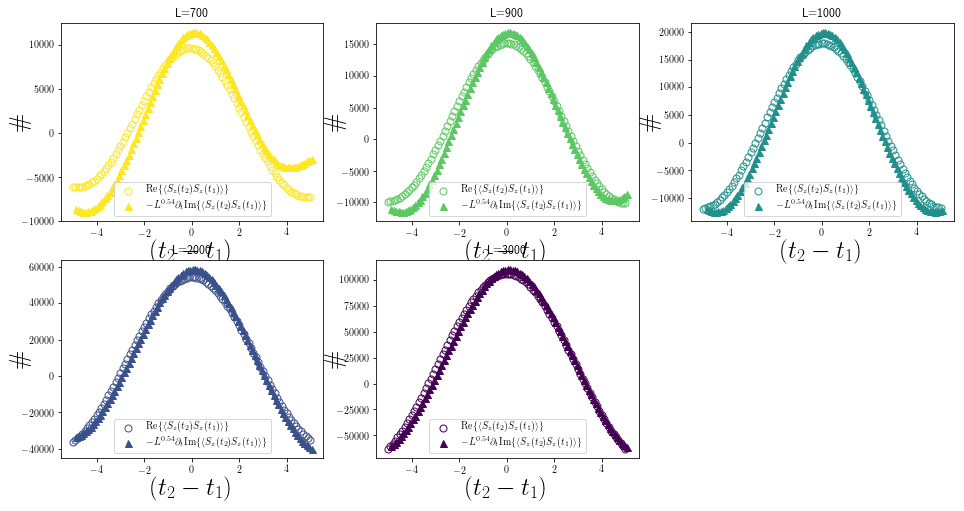

In [657]:
# derivative of the imaginary part compared to real part
#colormap
cmap=plt.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,np.size(Larr)))
typeID=1
t1arr=t1arrtype[typeID]
cmap=plt.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,np.size(Larr)))
correlationzvalsI_derivative=np.zeros((np.shape(correlationzvals)[0]-1,np.size(Larr),2))
for L,p in zip(Larr,range(np.size(Larr))):
    correlationzvalsI_derivative[:,p,typeID]=np.divide(np.diff(np.imag(correlationzvals[:,p,typeID])),np.diff((t2arr-t1arr[0])))
    
plt.figure(figsize=(16,8))
for L,p in zip(Larr,range(np.size(Larr))):
    plt.subplot(2,3,p+1)
    plt.plot((t2arr-t1arr[0]),(np.real(correlationzvals[:,p,typeID])),'o',color=colors[p],markerfacecolor='None',markersize=7,label='${\\rm Re}\{\\langle S_z(t_2)S_z(t_1)\\rangle\}$')
    #plt.plot((t2arr-t1arr[0]),(L**0.45)*(np.imag(correlationzvals[:,p,typeID])),'s',color=colors[-1],markerfacecolor='None',markersize=7,label='Imag')
    plt.plot((t2arr[1:]-t1arr[0]+(t2arr[1]-t2arr[0])/2),-(L**0.54)*correlationzvalsI_derivative[:,p,typeID],'^',color=colors[p],markersize=7,label='$-L^{0.54}\\partial_t{\\rm Im}\{\\langle S_z(t_2)S_z(t_1)\\rangle\}$')
    plt.title('L=%d'%L)
    plt.legend()
    plt.xlabel('$(t_2-t_1)$',fontsize=25)
    plt.ylabel('$\#$',fontsize=25,labelpad=-10)
#plt.xlim(-1,1)
#xticklabels(['$-1$','$-0.5$','$0$','$0.5$','$1$'],fontsize=15)
#plt.ylim(-0.23,0.23)
#ax2.set_yticks([-0.2,-0.1,0,0.1,0.2])
#ax2.set_yticklabels(['$-0.2$','$-0.1$','$0$','$0.1$','$0.2$'],fontsize=15)


/home/parajtitum/.local/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/parajtitum/.local/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


(0, 10)

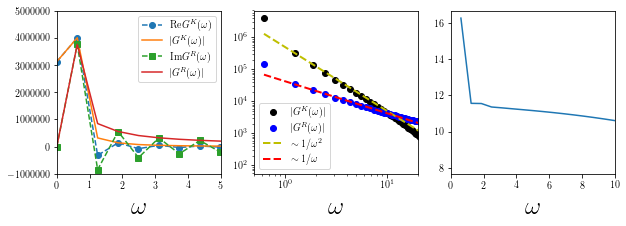

In [832]:
#Extract Effective temperature T(ω)
typeID=1
tvals=(t2arr-t1arr[0]) # has to be of the form -T to T 
Greal_ω=np.zeros((np.size(tvals),np.size(Larr),2),dtype=complex)
Gimag_ω=np.zeros((np.size(tvals),np.size(Larr),2),dtype=complex)
phasefactor=np.exp(-1j*np.pi*np.arange(np.size(tvals)))
phasefactorm=np.exp(-1j*np.pi*(np.arange(np.size(tvals))-np.size(tvals)//2))
for L,p in zip(Larr,range(np.size(Larr))):
    Greal_ω[:,p,typeID]=np.multiply(phasefactor,np.fft.fft(np.real(correlationzvals[:,p,typeID])))
    Gimag_ω[:,p,typeID]=np.multiply(phasefactor,np.fft.fft(np.imag(correlationzvals[:,p,typeID])))

ωarr=2*np.pi/((tvals[1]-tvals[0])*np.size(tvals))*(np.arange(np.size(tvals)))
p1=-1
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.plot(ωarr,np.real(Greal_ω[:,p1,typeID]),'--o',label='${\\rm Re}G^K(\\omega)$')   
plt.plot(ωarr,np.abs(Greal_ω[:,p1,typeID]),'-',label='$|G^K(\\omega)|$')  
plt.plot(ωarr,np.imag(Gimag_ω[:,p1,typeID])*Larr[p1]**0.4,'--s',label='${\\rm Im}G^R(\\omega)$')
plt.plot(ωarr,np.abs(Gimag_ω[:,p1,typeID])*Larr[p1]**0.4,'-',label='$|G^R(\\omega)|$')
plt.xlim(0,5)
plt.ylim(-1*10**6,5*10**6)
plt.xlabel("$\omega$",fontsize=25)
plt.legend(loc=1)
plt.subplot(1,3,2)
plt.loglog(ωarr,np.abs((Greal_ω[:,p1,typeID])),'ko',label='$|G^K(\\omega)|$')
plt.loglog(ωarr,np.abs((Gimag_ω[:,p1,typeID])),'bo',label='$|G^R(\\omega)|$')
plt.loglog(ωarr,10**5.7/ωarr**2,'y--',label='$\sim 1/\\omega^2$',linewidth=2) 
plt.loglog(ωarr,10**4.63/ωarr,'r--',label='$\sim 1/\\omega$',linewidth=2)
plt.xlim(0,20)
plt.legend(loc=3)
plt.xlabel("$\omega$",fontsize=25)
plt.subplot(1,3,3)
#
plt.plot(ωarr[1:40],np.divide(np.real(Greal_ω[1:40,p1,typeID])*ωarr[1:40],np.imag(Gimag_ω[1:40,p1,typeID])),'-',label='$G^K(\\omega)/G^R(\\omega)$')    
#plt.loglog(ωarr[1:40],1/ωarr[1:40]**2,'-',label='$G^K(\\omega)/G^R(\\omega)$')    
#plt.ylabel('$T_{\\rm{eff}}$',labelpad=-18,fontsize=25)   
plt.xlabel("$\omega$",fontsize=25)
plt.xlim(0,10)
    

Let us now look at Type-I quench and compare the effective temperature as obtained from Holstein primakoff.
From HP calculation, we expect, with $(\gamma_x=1,\gamma_y=0)$
\begin{equation}
    T^{\rm HP}_{\rm eff}==2*\frac{m_0\Omega_0}{8m^2}=2*\frac{\Gamma^2}{2} \sqrt{\frac{(\Gamma_0-J)}{\Gamma_0}}
\end{equation}

In [58]:
#two-time correlator definitions
Larr=[700,900,1000,2000,3000]#,4000]#np.concatenate([np.arange(100,1100,100),np.arange(2000,10000,1000)])
t1arrtype=[np.array([15.]),np.array([20.])]# t1arr for type 1 and type III
t2arr=np.linspace(10,50,int((50-10)/1.0)+1)#np.linspace(15,25,int((25-15)/0.1)+1)#np.linspace(10,50,int((50-10)/1.0)+1)#np.linspace(0,10,int((10-0)/0.2)+1)
Azf=1.
Ayf=0.
#Types of quenches I,III indexed by typeID 0,1 and 2 respectively
initparams=np.array([[1.,0.,4.],[0.,1.,1.]])#{γz,γy,Γ}, and rows indicated type
quenchparams=np.array([[1.,0.,1.],[1.,0.,1.]])

In [59]:
#Load two-time correlation data 
#load two time correlation <Sϕ(t2)Sϕ(t1)> from file
directory1='data/Twotimecorrelation/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/'
directory5='/home/parajtitum/Dropbox/Research_Projects_Current/LMG_Quench/'
correlationyvals=np.zeros((np.size(t2arr),np.size(Larr),2),dtype=complex)
correlationzvals=np.zeros((np.size(t2arr),np.size(Larr),2),dtype=complex)
deletelist=np.array([],dtype=int)
for typeID in range(0,1):
    for L,p in zip(Larr,range(np.size(Larr))):
        #print('L='+str(L))#, end='\r', flush=True)
        paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=initparams[typeID,0],γy=initparams[typeID,1],Γ=initparams[typeID,2])
        paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=quenchparams[typeID,0],γy=quenchparams[typeID,1],Γ=quenchparams[typeID,2])
        t1arr=t1arrtype[typeID]
        #load Sz^2 data
        filename1=directory5+'data/Twotimecorrelation/Twotimecorrelator_Az_1.0_Ay_0.0_t1_'+LMG.arrtostr(t1arr)+'_t2_'+LMG.arrtostr(t2arr)+'_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
        #load Sy^2 data
        filename2=directory5+'data/Twotimecorrelation/Twotimecorrelator_Az_0.0_Ay_1.0_t1_'+LMG.arrtostr(t1arr)+'_t2_'+LMG.arrtostr(t2arr)+'_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
        #print(filename1)
        if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
            print("L="+str(L)+" data doesn't exist!")
            deletelist=np.append(deletelist,int(p))
        else:
            #print("Loading files:\n "+filename1+"\n"+filename2)
            with h5py.File(filename1, "r") as f:
                correlationzarr= f["correlationarr"][...]
            with h5py.File(filename2, "r") as f:
                correlationyarr= f["correlationarr"][...]
            correlationzvals[:,p,typeID]=correlationzarr
            correlationyvals[:,p,typeID]=correlationyarr

Text(-0.29, -0.025, '$\\overbrace{\\hspace{1in}}$')

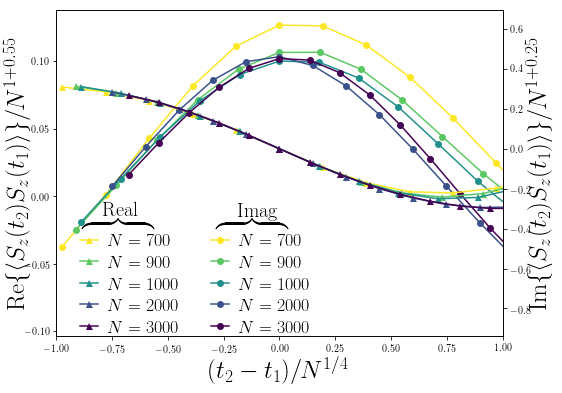

In [43]:
#Scaling collapse for real and imaginary parts of the twotime correlation functions

#colormap
cmap=plt.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,np.size(Larr)))

mzRvals=[0.55,0.64]
mtRvals=[0.25,1./6.]
mzIvals=[1./4.,0.2]
mtIvals=[0.25,1./6.]
fig,ax2=plt.subplots(figsize=(8,6))
######################type I####################
typeID=0
t1arr=t1arrtype[typeID]
#finite size scaling collapse
for L,p in zip(Larr,range(np.size(Larr))):
    #print(p)
    ax2.plot((t2arr-t1arr[0])/L**mtRvals[typeID],(np.real(correlationzvals[:,p,typeID]))/L**(1+mzRvals[typeID]),'-o',color=colors[p],markersize=7,markeredgewidth=0,label='$N=%d$'% L)
ax2.set_xlabel('$(t_2-t_1)/N^{1/4}$',fontsize=25)
ax2.set_ylabel('${\\rm Re}\{\\langle S_z(t_2)S_z(t_1)\\rangle\}/N^{1+0.55}$',fontsize=25,labelpad=-10)
ax2.set_xlim(-1,1)
#ax2.set_xticklabels(['$-1$','$-0.5$','$0$','$0.5$','$1$'],fontsize=15)
#ax2.set_ylim(-0.23,0.23)
#ax2.set_yticks([-0.2,-0.1,0,0.1,0.2])
#ax2.set_yticklabels(['$-0.2$','$-0.1$','$0$','$0.1$','$0.2$'],fontsize=15)
ax2I = ax2.twinx()
for L,p in zip(Larr,range(np.size(Larr))):
    #print(p)
    ax2I.plot((t2arr-t1arr[0])/L**mtIvals[typeID],(np.imag(correlationzvals[:,p,typeID]))/L**(1+mzIvals[typeID]),'-^',color=colors[p],markersize=7,markeredgewidth=0,label='$N=%d$'% L)
ax2I.set_xlabel('$(t_2-t_1)/N^{1/4}$',fontsize=25)
ax2I.set_ylabel('${\\rm Im}\{\\langle S_z(t_2)S_z(t_1)\\rangle\}/N^{1+0.25}$',fontsize=25,labelpad=-1)
ax2I.set_xlim(-1,1)
#ax2I.set_ylim(-0.23,0.23)
#ax2I.set_ylim(-0.1,0.1)
#ax2I.set_yticks([-0.2,-0.1,0,0.1,0.2])
#ax2I.set_yticklabels(['$-0.2$','$-0.1$','$0$','$0.1$','$0.2$'],fontsize=15)
#legends
ax2.legend(fontsize=18,frameon=False,bbox_to_anchor=(0.31,0.37),ncol=1,numpoints=1,handlelength=1,markerscale=1,columnspacing=0.5,labelspacing=0.2,handletextpad=0.5)
ax2I.legend(fontsize=18,frameon=False,bbox_to_anchor=(0.31,0.37),ncol=1,numpoints=1,handlelength=1,markerscale=1,columnspacing=0.5,labelspacing=0.2,handletextpad=0.5)
ax2.text(-0.79,-0.015,"${\\rm Real}$",fontsize=20)
ax2.text(-0.89,-0.025,"$\overbrace{\\hspace{1in}}$",fontsize=20)
ax2.text(-0.19,-0.015,"${\\rm Imag}$",fontsize=20)
ax2.text(-0.29,-0.025,"$\overbrace{\\hspace{1in}}$",fontsize=20)

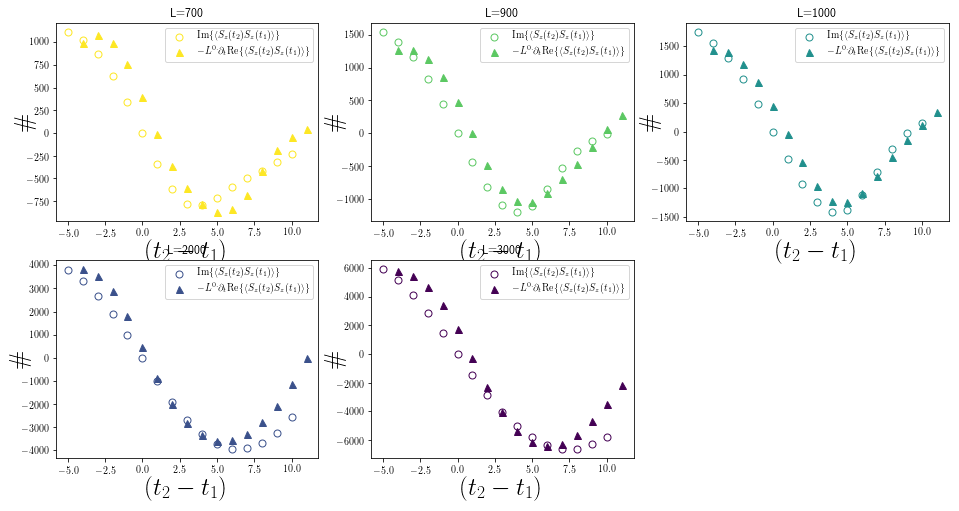

In [91]:
# derivative of the imaginary part compared to real part
#colormap
cmap=plt.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,np.size(Larr)))
typeID=0
t1arr=t1arrtype[typeID]
cmap=plt.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,np.size(Larr)))
correlationzvalsR_derivative=np.zeros((np.shape(correlationzvals)[0]-1,np.size(Larr),2))
for L,p in zip(Larr,range(np.size(Larr))):
    correlationzvalsR_derivative[:,p,typeID]=np.divide(np.diff(np.real(correlationzvals[:,p,typeID])),np.diff((t2arr-t1arr[0])))
    
plt.figure(figsize=(16,8))
for L,p in zip(Larr,range(np.size(Larr))):
    plt.subplot(2,3,p+1)
    plt.plot((t2arr[:16]-t1arr[0]),(np.imag(correlationzvals[:16,p,typeID])),'o',color=colors[p],markerfacecolor='None',markersize=7,label='${\\rm Im}\{\\langle S_z(t_2)S_z(t_1)\\rangle\}$')
    #plt.plot((t2arr-t1arr[0]),(L**0.45)*(np.imag(correlationzvals[:,p,typeID])),'s',color=colors[-1],markerfacecolor='None',markersize=7,label='Imag')
    plt.plot((t2arr[1:17]-t1arr[0]),correlationzvalsR_derivative[:16,p,typeID],'^',color=colors[p],markersize=7,label='$-L^{0.}\\partial_t{\\rm Re}\{\\langle S_z(t_2)S_z(t_1)\\rangle\}$')
    #plt.xlim(-1*L**0.25,1*L**0.25)
    plt.title('L=%d'%L)
    plt.legend()
    plt.xlabel('$(t_2-t_1)$',fontsize=25)
    plt.ylabel('$\#$',fontsize=25,labelpad=-10)
#plt.xlim(-1,1)
#xticklabels(['$-1$','$-0.5$','$0$','$0.5$','$1$'],fontsize=15)
#plt.ylim(-0.23,0.23)
#ax2.set_yticks([-0.2,-0.1,0,0.1,0.2])
#ax2.set_yticklabels(['$-0.2$','$-0.1$','$0$','$0.1$','$0.2$'],fontsize=15)

(0, 3)

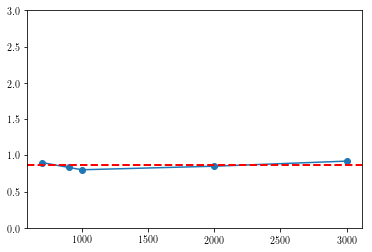

In [86]:
#plot ratio of derivative with real part as a function of L
#plot for t_2-t_1=0 
Teff=2*(0.5*(paramvalsf.Γ)**2)*np.sqrt(1-paramvals0.J/paramvals0.Γ)
plt.plot(Larr,np.divide(np.average(correlationzvalsR_derivative[5:16,:,0],axis=0),np.average(np.imag(correlationzvals[5:16,:,0]),axis=0)),'-o')
plt.axhline(y=Teff,linestyle='--',color='red',linewidth=2)
#plt.loglog(Larr,list(map(lambda x:pow(x,-0.35),Larr)),'--')
plt.ylim((0,3))

In [50]:
np.real(correlationzvals[5,:,0])

array([  3262.82908065,   4048.28801239,   4479.76419285,  13544.33855906,
        25037.09660408])

In [51]:
-correlationzvalsI_derivative[5,:,typeID]

array([  335.95529576,   436.36326575,   486.51861493,   980.86108251,
        1475.15308355])